# Grouping classical HLA alleles by lead eQTLs

Last updated July 2023

Joyce Kang

Goal: Figure out which HLA alleles are on the same haplotype as eQTL variants.

In [1]:
suppressPackageStartupMessages({
    library(vcfR)
    library(tidyverse)
    library(data.table)
    library(RColorBrewer)
})

source('../scripts/utils.R')

## Read in WGS HLA reference

In [2]:
vcf_filepath = '../data/MHC_reference/ALL3.merged.4digit.4field.conv.all_QC.ref_aligned.eagle.vcf' # Takes a long time
vcf = read.vcfR(vcf_filepath)

vcf@fix[,'ID'] = gsub("\\;..*","",vcf@fix[,'ID'])
vcf@fix %>% head()

# Grab the HLA alleles
idx_HLA = which(startsWith(vcf@fix[,'ID'], 'HLA_'))
length(idx_HLA)
vcf_HLA = vcf[idx_HLA,]
#vcf_HLA@gt

Scanning file to determine attributes.
File attributes:
  meta lines: 7
  header_line: 8
  variant count: 22733
  column count: 20358
Meta line 7 read in.
All meta lines processed.
gt matrix initialized.
Character matrix gt created.
  Character matrix gt rows: 22733
  Character matrix gt cols: 20358
  skip: 0
  nrows: 22733
  row_num: 0
Processed variant: 22733
All variants processed


CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
6,27970031,rs149946,G,T,NA,PASS,NA
6,27976200,rs9380032,G,T,NA,PASS,NA
6,27979188,rs4141691,A,G,NA,PASS,NA
6,27979625,rs10484402,A,G,NA,PASS,NA
6,27981673,rs9368540,G,A,NA,PASS,NA
6,27984726,rs74505854,A,C,NA,PASS,NA


[1] 570

In [3]:
# Get the lead variants from pseudobulk analysis
variants_B = read.csv('./4_multidataset_eQTLs/B_plasma_lead_variants.csv')$variant
variants_M = read.csv('./4_multidataset_eQTLs/Myeloid_lead_variants.csv')$variant
variants_T = read.csv('./4_multidataset_eQTLs/T_lead_variants.csv')$variant
variants = c(variants_B, variants_M, variants_T) %>% unique()

length(variants)

# Grab the variant from reference
idx = which(vcf@fix[,'ID'] %in% variants)

vcf_variants = vcf[idx,]
#vcf_variants@gt
vcf_variants@fix %>% head(4)
variants[which(! variants %in% vcf_variants@fix[,'ID'])]

[1] 21

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
6,29916505,rs417162,C,T,NA,PASS,NA
6,29919779,rs7747253,C,A,NA,PASS,NA
6,31236467,rs2524096,G,T,NA,PASS,NA
6,31240692,rs2395471,G,A,NA,PASS,NA


[1] "HLA_B_15"       "HLA_C_07"       "HLA_DPB1_04.02"

In [4]:
# Grab the HLA alleles for the eGene
idx_HLA_gene = which(startsWith(vcf_HLA@fix[, 'ID'], 'HLA_B'))
vcf_HLA_gene = vcf_HLA[idx_HLA_gene, ]
vcf_HLA_gene@fix %>% head(4)

CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO
6,31321649,HLA_B*07,A,T,NA,PASS,NA
6,31321650,HLA_B*07:02,A,T,NA,PASS,NA
6,31321651,HLA_B*07:04,A,T,NA,PASS,NA
6,31321652,HLA_B*07:05,A,T,NA,PASS,NA


In [5]:
# Split 0|0 into separate rows, each for 1 chromosome
splitIndividual = function(sample) {
    indiv = HLA_occ[sample, ]
    # for the first chromosome, take only values to the left of the pipe
    # for the second chromosome, take only values to the right of the pipe
    r = rbind(word(indiv, 1, sep = "\\|"), word(indiv, 2, sep = "\\|")) %>% as.data.frame()
    rownames(r) = paste(rownames(indiv)[1], seq(1:2), sep = '_')
    colnames(r) = colnames(HLA_occ)
    return(r)
}

In [6]:
HLA_occ = vcf_HLA@gt %>% t() %>% as.data.frame()
HLA_occ = HLA_occ[-1, ] # remove format column
colnames(HLA_occ) = vcf_HLA@fix[,'ID']
HLA_occ[1:5, 1:5]
HLA_occs = map_df(rownames(HLA_occ), splitIndividual)
dim(HLA_occs)

,HLA_A*01,HLA_A*01:01,HLA_A*01:02,HLA_A*01:136,HLA_A*02
,<chr>,<chr>,<chr>,<chr>,<chr>
2N005,0|0,0|0,0|0,0|0,0|0
2N007,0|0,0|0,0|0,0|0,1|0
2N040,0|0,0|0,0|0,0|0,0|1
E00859946,0|0,0|0,0|0,0|0,0|0
HG00096,0|1,0|1,0|0,0|0,0|0


[1] 40698   570

## Save allele occurrences for each HLA gene

In [7]:
## Do this for each HLA gene
for (gene in c('A', 'B', 'C', 'DRB1', 'DQA1', 'DQB1', 'DPA1', 'DPB1')) {
    message(gene)
    idx_HLA = which(startsWith(vcf@fix[,'ID'], paste0('HLA_', gene)))
    length(idx_HLA)
    vcf_HLA = vcf[idx_HLA,]
    HLA_occ = vcf_HLA@gt %>% t() %>% as.data.frame()
    HLA_occ = HLA_occ[-1, ] # remove format column
    colnames(HLA_occ) = vcf_HLA@fix[,'ID']
    HLA_occs = map_df(rownames(HLA_occ), splitIndividual)
    saveRDS(HLA_occs, paste0('7_HLA_occurrences/HLA-', gene, '_occurrences.rds'))
}

A

B

C

DRB1

DQA1

DQB1

DPA1

DPB1



In [8]:
HLA_occs_example = readRDS(paste0('7_HLA_occurrences/HLA-B_occurrences.rds'))
head(HLA_occs_example)

,HLA_B*07,HLA_B*07:02,HLA_B*07:04,HLA_B*07:05,HLA_B*07:09,HLA_B*08,HLA_B*08:01,HLA_B*13,HLA_B*13:01,HLA_B*13:02,⋯,HLA_B*67:01,HLA_B*73,HLA_B*73:01,HLA_B*78,HLA_B*78:01,HLA_B*81,HLA_B*81:01,HLA_B*82,HLA_B*82:01,HLA_B*82:02
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
2N005_1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2N005_2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2N007_1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2N007_2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2N040_1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2N040_2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Save allele occurrences for each lead eQTL variant

In [9]:
splitIndividualVariants = function(sample) {
    indiv = variants_occ[sample, ]
    # for the first chromosome, take only values to the left of the pipe
    # for the second chromosome, take only values to the right of the pipe
    r = rbind(word(indiv, 1, sep = "\\|"), word(indiv, 2, sep = "\\|")) %>% as.data.frame()
    rownames(r) = paste(rownames(indiv)[1], seq(1:2), sep = '_')
    colnames(r) = colnames(variants_occ)
    return(r)
}

In [10]:
vcf_variants@fix[,'ID']
variants_occ = vcf_variants@gt %>% t() %>% as.data.frame()
variants_occ = variants_occ[-1, ] # remove format column
names(variants_occ) = paste(vcf_variants@fix[,'ID'])#, vcf_variants@fix[,'REF'], vcf_variants@fix[,'ALT'], sep = '_')
variants_occs = map_df(rownames(variants_occ), splitIndividualVariants)
saveRDS(variants_occs, paste0('7_HLA_occurrences/', 'leadeQTL_occurrences.rds'))

[1] "rs417162"   "rs7747253"  "rs2524096"  "rs2395471"  "rs9271112" 
 [6] "rs9271117"  "rs3104413"  "rs9271375"  "rs3104371"  "rs17205184"
[11] "rs9272271"  "rs9272346"  "rs3828789"  "rs2163472"  "rs2395305" 
[16] "rs17220674" "rs13203715" "rs1431403"

## Get HLA alleles found in the study

In [11]:
HLA_alleles_study = rbind(read.csv('../data/hla_alleles/HLA_alleles_table_OneK1K.csv', row.names = 1) %>%
                            mutate(dataset = 'OneK1K'),
                         read.csv('../data/hla_alleles/HLA_alleles_table_AMP2RA.csv', row.names = 1) %>%
                            mutate(dataset = 'AMP2RA'),
                         read.csv('../data/hla_alleles/HLA_alleles_table_Smillie_ccdg.csv', row.names = 1)%>%
                            mutate(dataset = 'Smillie2019'),
                         read.csv('../data/hla_alleles/HLA_alleles_table_Smillie_Helmsley.csv', row.names = 1) %>%
                            mutate(dataset = 'Smillie2019'),
                         read.csv('../data/hla_alleles/HLA_alleles_table_Randolph.csv', row.names = 1) %>%
                            mutate(dataset = 'Randolph2021'))
HLA_alleles_study %>% head(4)
HLA_alleles_study$Sample %>% unique() %>% length()

,Geno_ID,Sample,Allele,Gene,GT,dosage,dataset
,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
1,691_692,691_692,HLA_A*02:01,HLA_A,1|0,0.98,OneK1K
2,691_692,691_692,HLA_A*69:01,HLA_A,0|1,1.00,OneK1K
3,691_692,691_692,HLA_C*06:02,HLA_C,1|1,2.00,OneK1K
4,691_692,691_692,HLA_B*13:02,HLA_B,0|1,1.00,OneK1K


[1] 1146

## Calculate co-occurrence for one eQTL-HLA gene pair

In [12]:
make_cooccurrence_plot = function(variant, gene) {
    hla_occs_mat = apply(hla_occs, 2, as.numeric)
    variant_occs_mat = apply(variant_occs, 2, as.numeric)
    rownames(hla_occs_mat) = rownames(hla_occs)
    rownames(variant_occs_mat) = rownames(variant_occs)
    
    mat = cbind(variant_occs_mat[, variant], hla_occs_mat) %>% as.data.frame()
    colnames(mat)[1] = 'eQTL'
    
    result = list()
    for (HLA_allele in colnames(hla_occs_mat)){
        mat_subset = mat %>% filter(get(HLA_allele) == 1)
        allele_2dig = unlist(strsplit(unlist(strsplit(HLA_allele, '\\*'))[2], '\\:'))[1]
        # What percent have eQTL?
        percent = sum(mat_subset$eQTL) / length(mat_subset$eQTL)
        result[[HLA_allele]] = data.frame(variant = variant, gene = gene,
                                      HLA_allele = HLA_allele,
                                      allele_2dig = allele_2dig,
                                      nALT_eQTL = sum(mat_subset$eQTL), 
                                      nREF_eQTL = sum(mat_subset$eQTL == 0),
                                      nMHCRefIndivs = length(mat_subset$eQTL),
                                      percALT = percent)
    }
    result = result %>% map_df(rbind) %>% arrange(-percALT)
    output = list()
    output[['result']] = result
    
    p = ggplot(result) +
        geom_point(aes(x = reorder(HLA_allele, -percALT), y = percALT, size = nMHCRefIndivs, col = allele_2dig)) + 
        ylab('Prop. of MHC reference haplotypes\n with eQTL ALT allele') + xlab('HLA allele') + ylim(0, 1) +
        theme_bw() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + ggtitle(paste0('eQTL variant: ', result$variant)) +
        guides(col = guide_legend(ncol = 2)) + 
        scale_color_manual(values = colorRampPalette(c(brewer.pal(8, "Set2"), brewer.pal(8, "Set1")))(35))
    output[['p']] = p
    return(output)
}

In [13]:
variant_occs = readRDS('7_HLA_occurrences/leadeQTL_occurrences.rds')
colnames(variant_occs)

[1] "rs417162"   "rs7747253"  "rs2524096"  "rs2395471"  "rs9271112" 
 [6] "rs9271117"  "rs3104413"  "rs9271375"  "rs3104371"  "rs17205184"
[11] "rs9272271"  "rs9272346"  "rs3828789"  "rs2163472"  "rs2395305" 
[16] "rs17220674" "rs13203715" "rs1431403"

In [14]:
variant_occs[1:5, 1:5]

,rs417162,rs7747253,rs2524096,rs2395471,rs9271112
,<chr>,<chr>,<chr>,<chr>,<chr>
2N005_1,1,1,0,0,0
2N005_2,1,1,1,1,1
2N007_1,1,1,1,1,0
2N007_2,1,1,1,1,0
2N040_1,1,1,1,1,1


In [15]:
lead_variants_B = read.csv('./4_multidataset_eQTLs/B_plasma_lead_variants.csv')
lead_variants_M = read.csv('./4_multidataset_eQTLs/Myeloid_lead_variants.csv')
lead_variants_T = read.csv('./4_multidataset_eQTLs/T_lead_variants.csv')
leads = rbind(lead_variants_B, lead_variants_M, lead_variants_T)

## Restrict to HLA alleles found in our cohorts

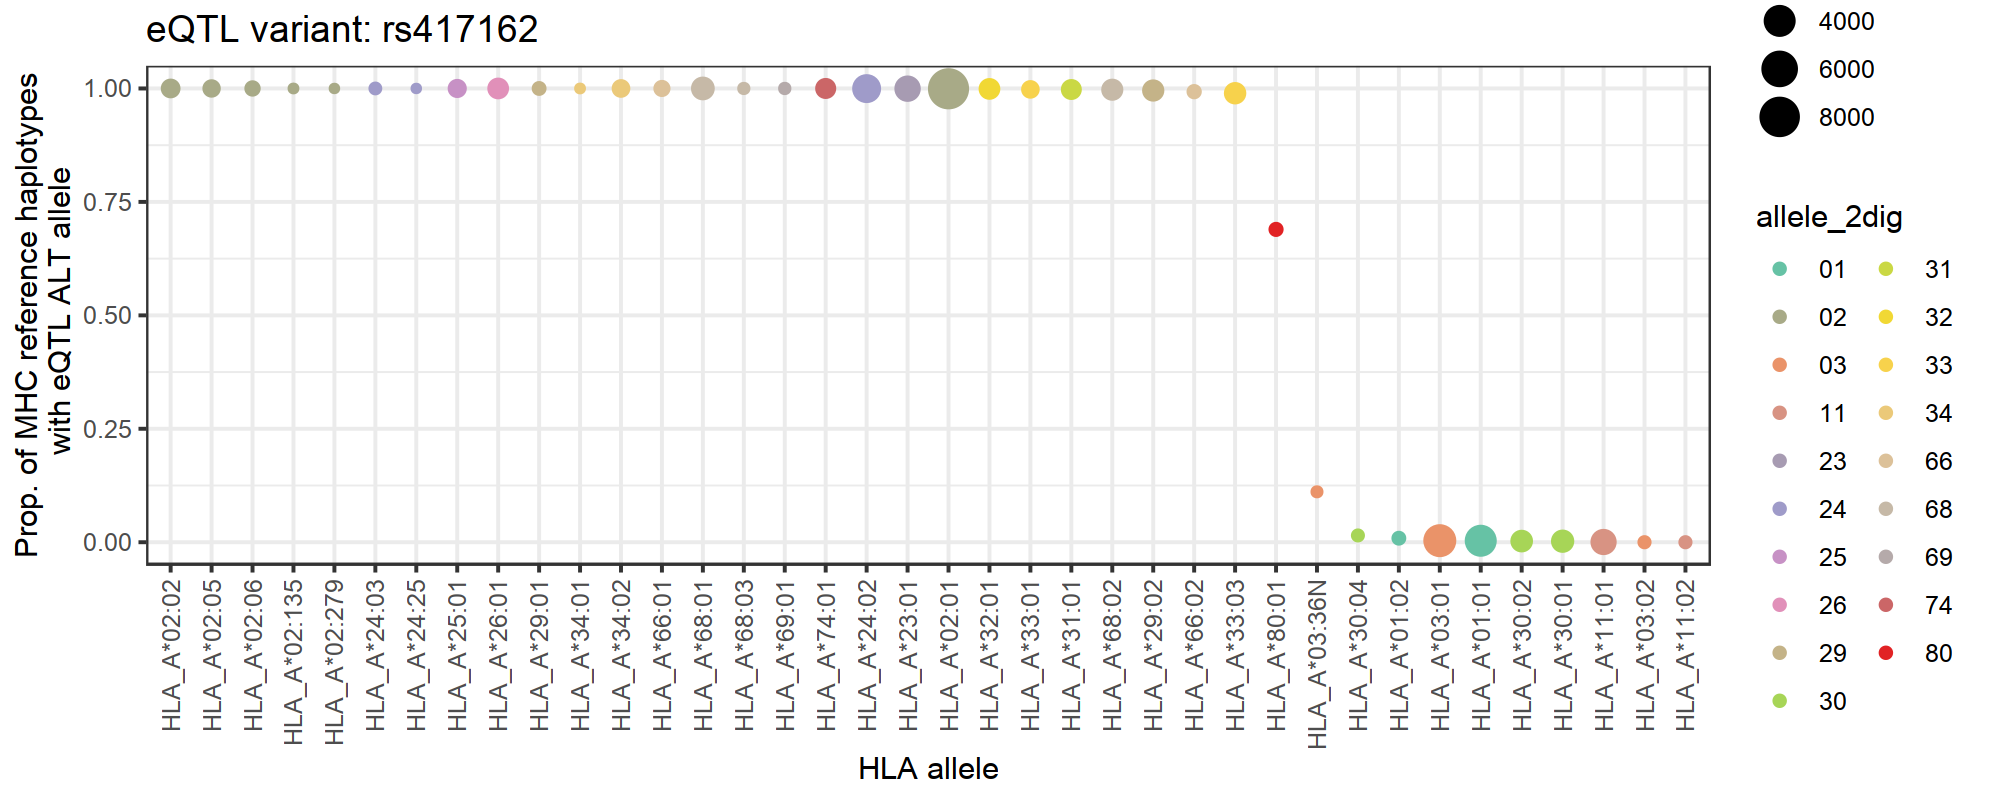

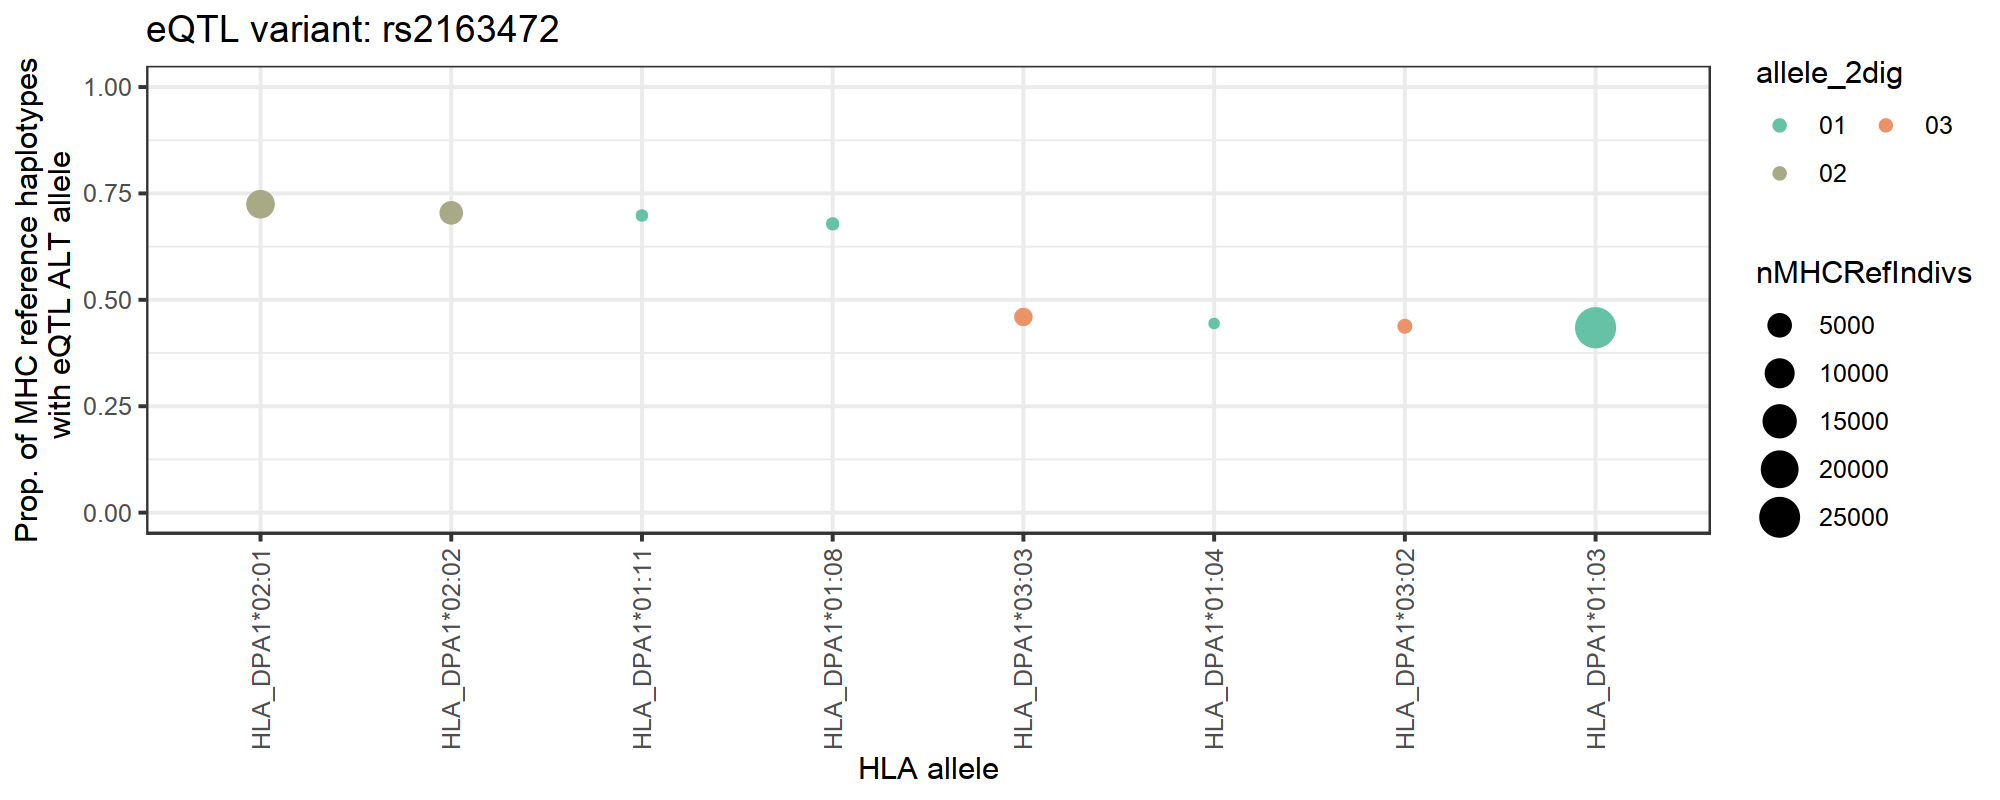

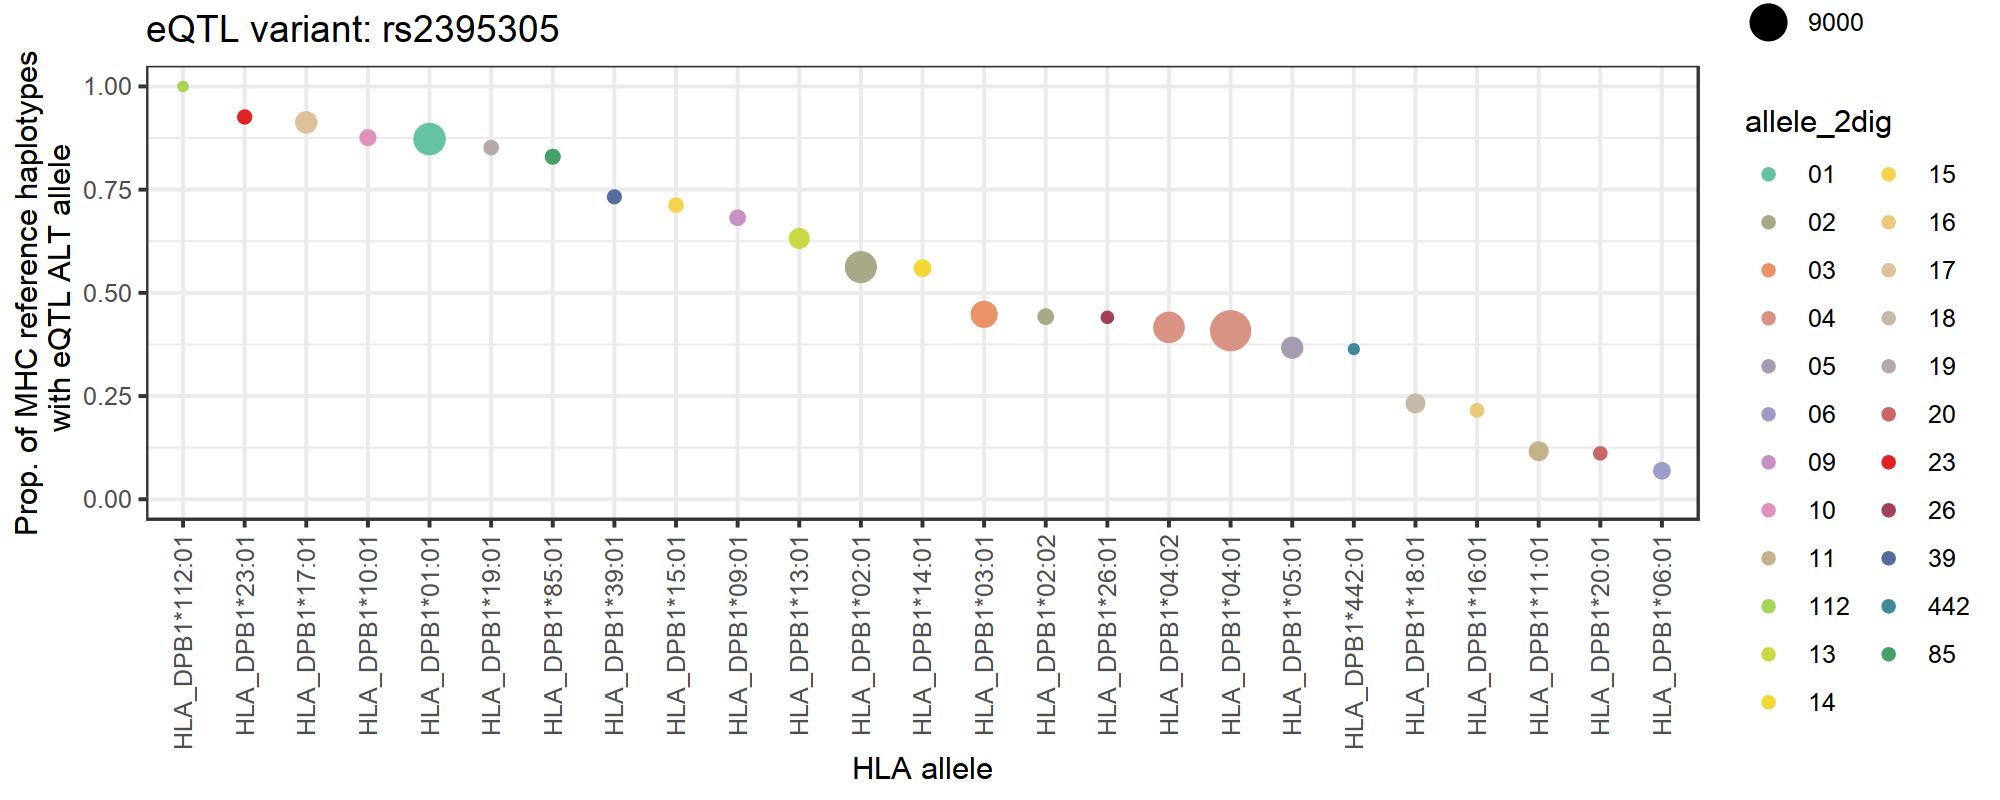

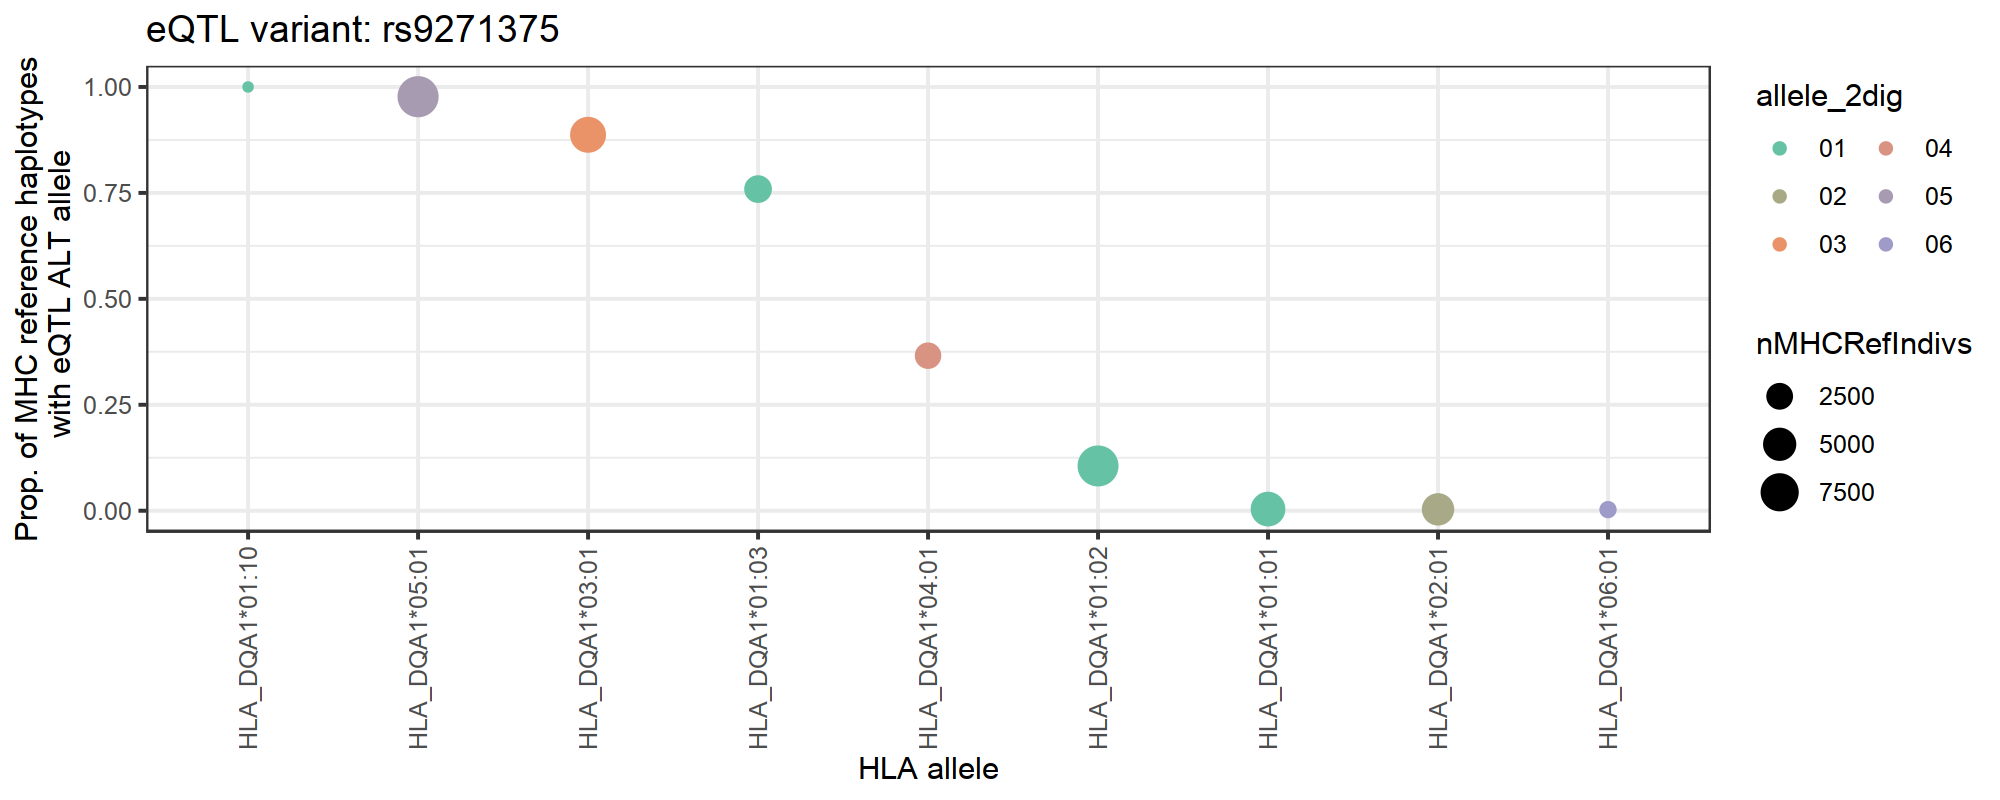

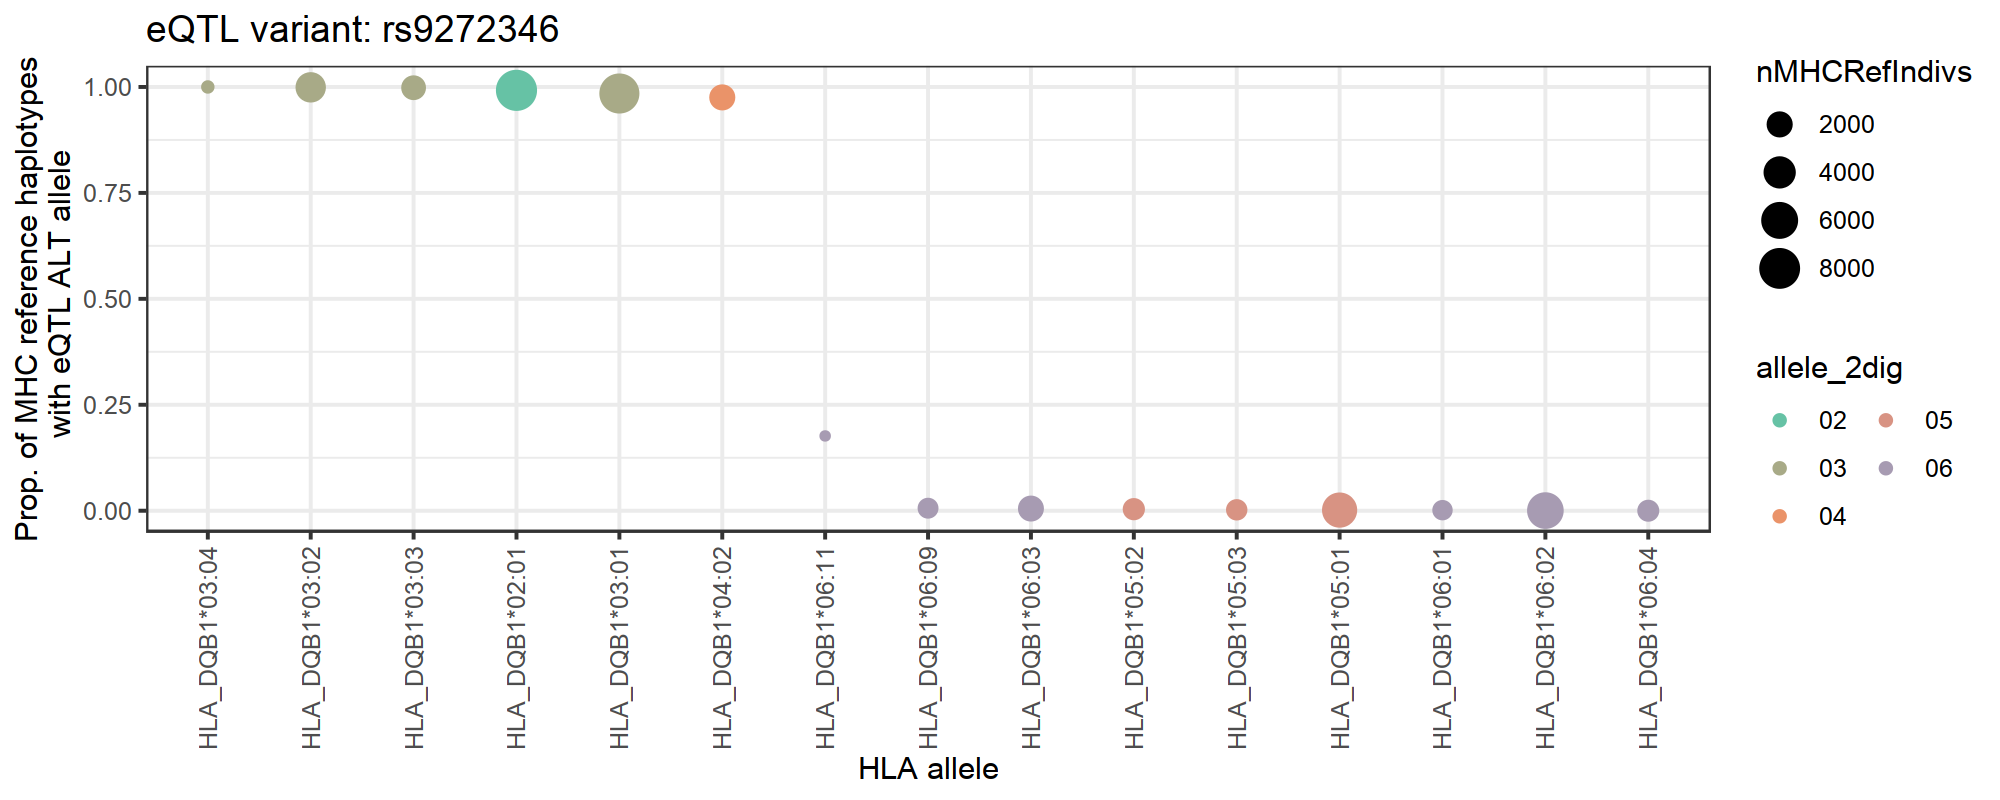

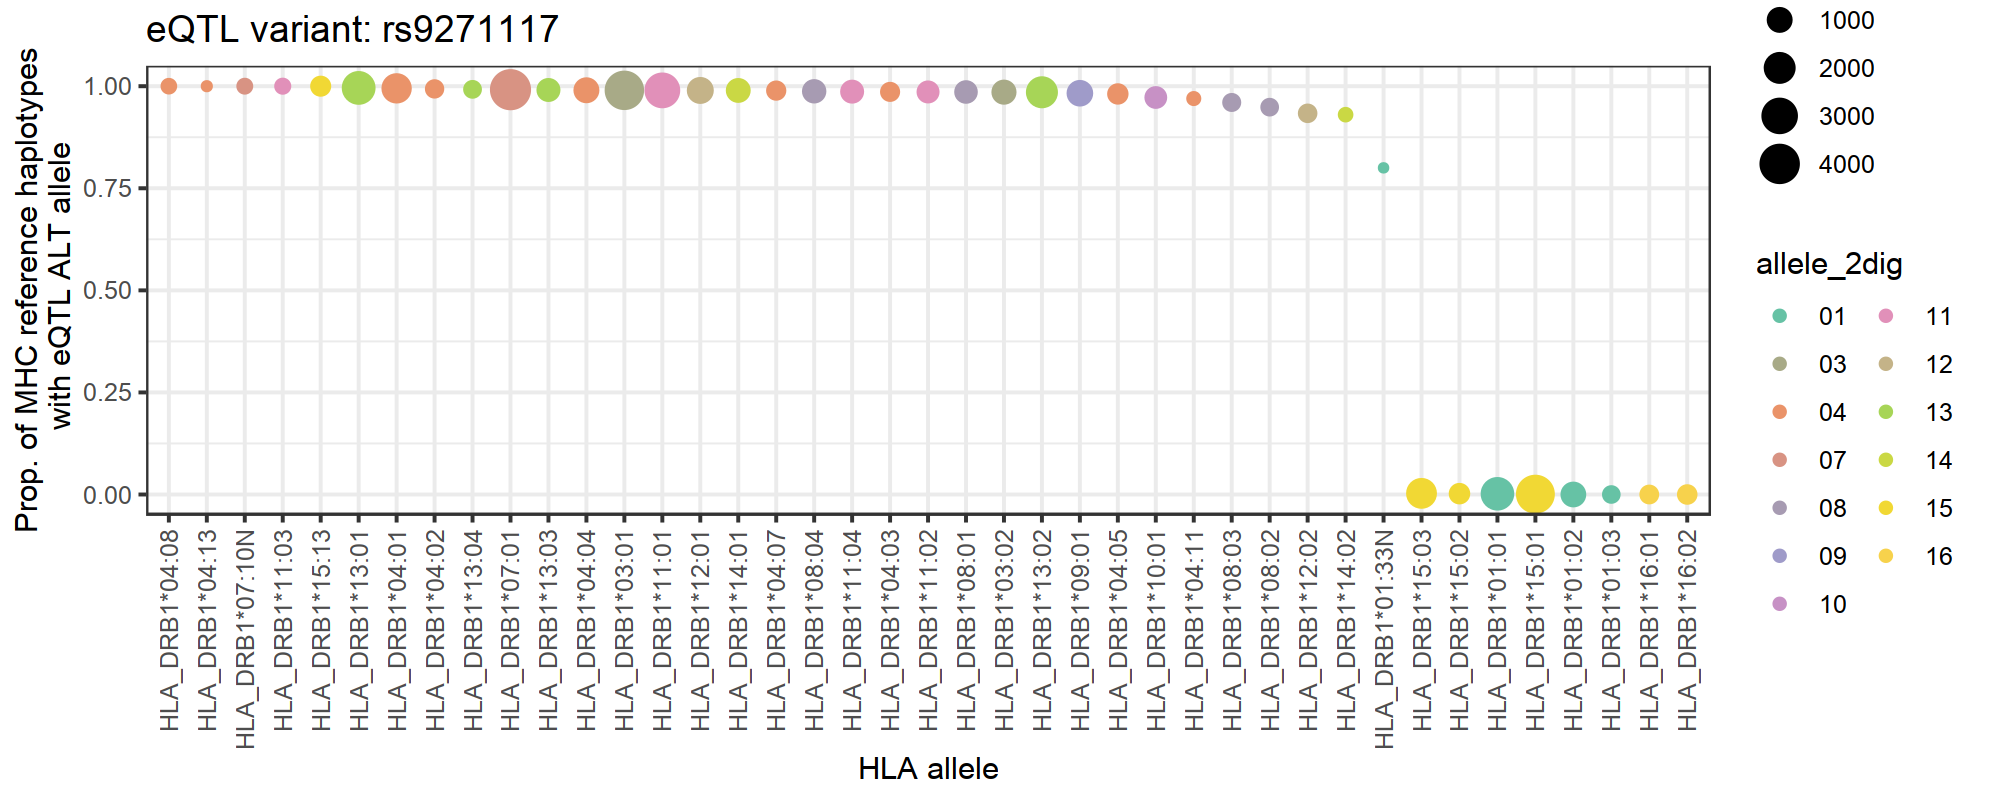

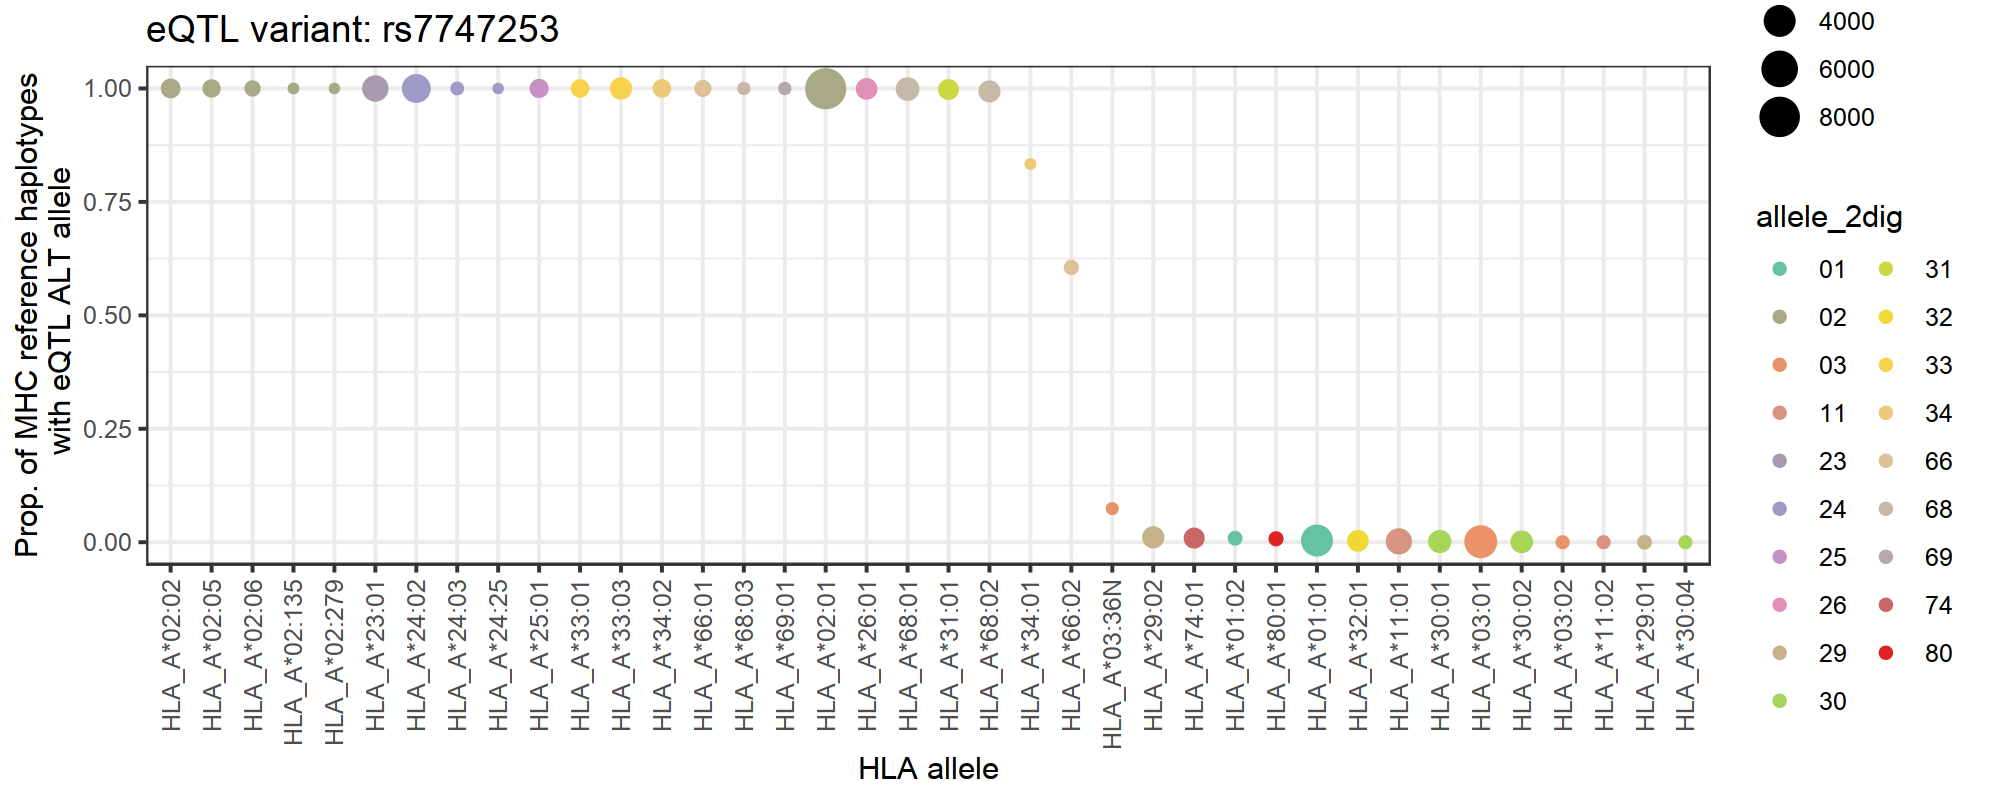

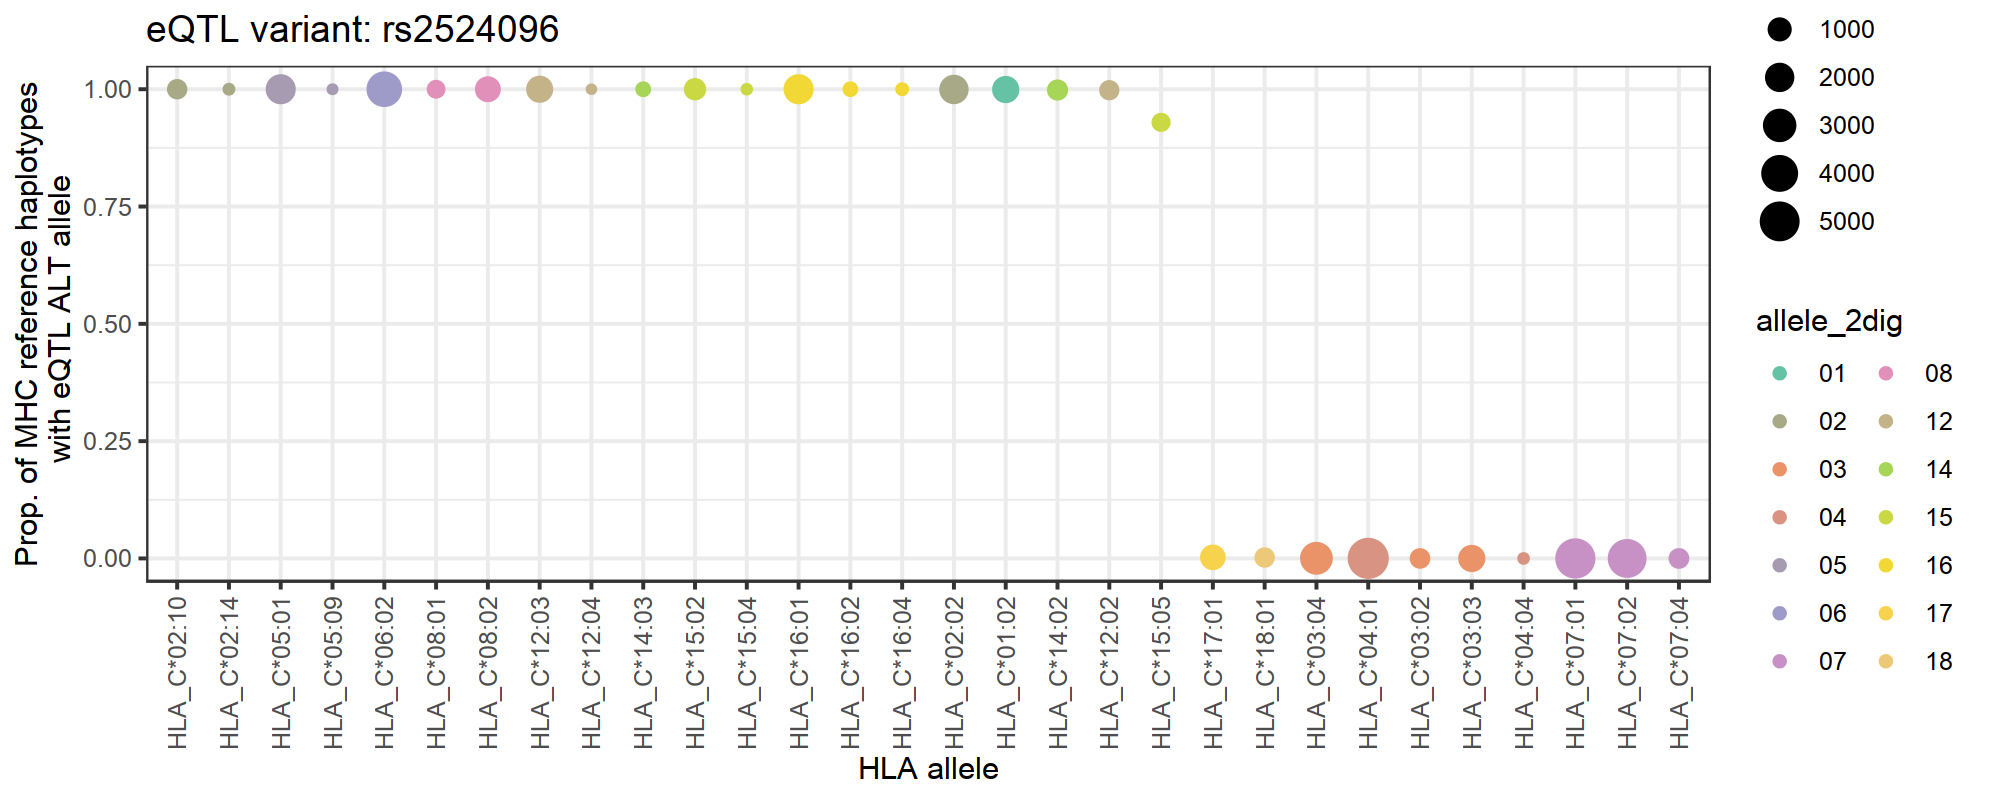

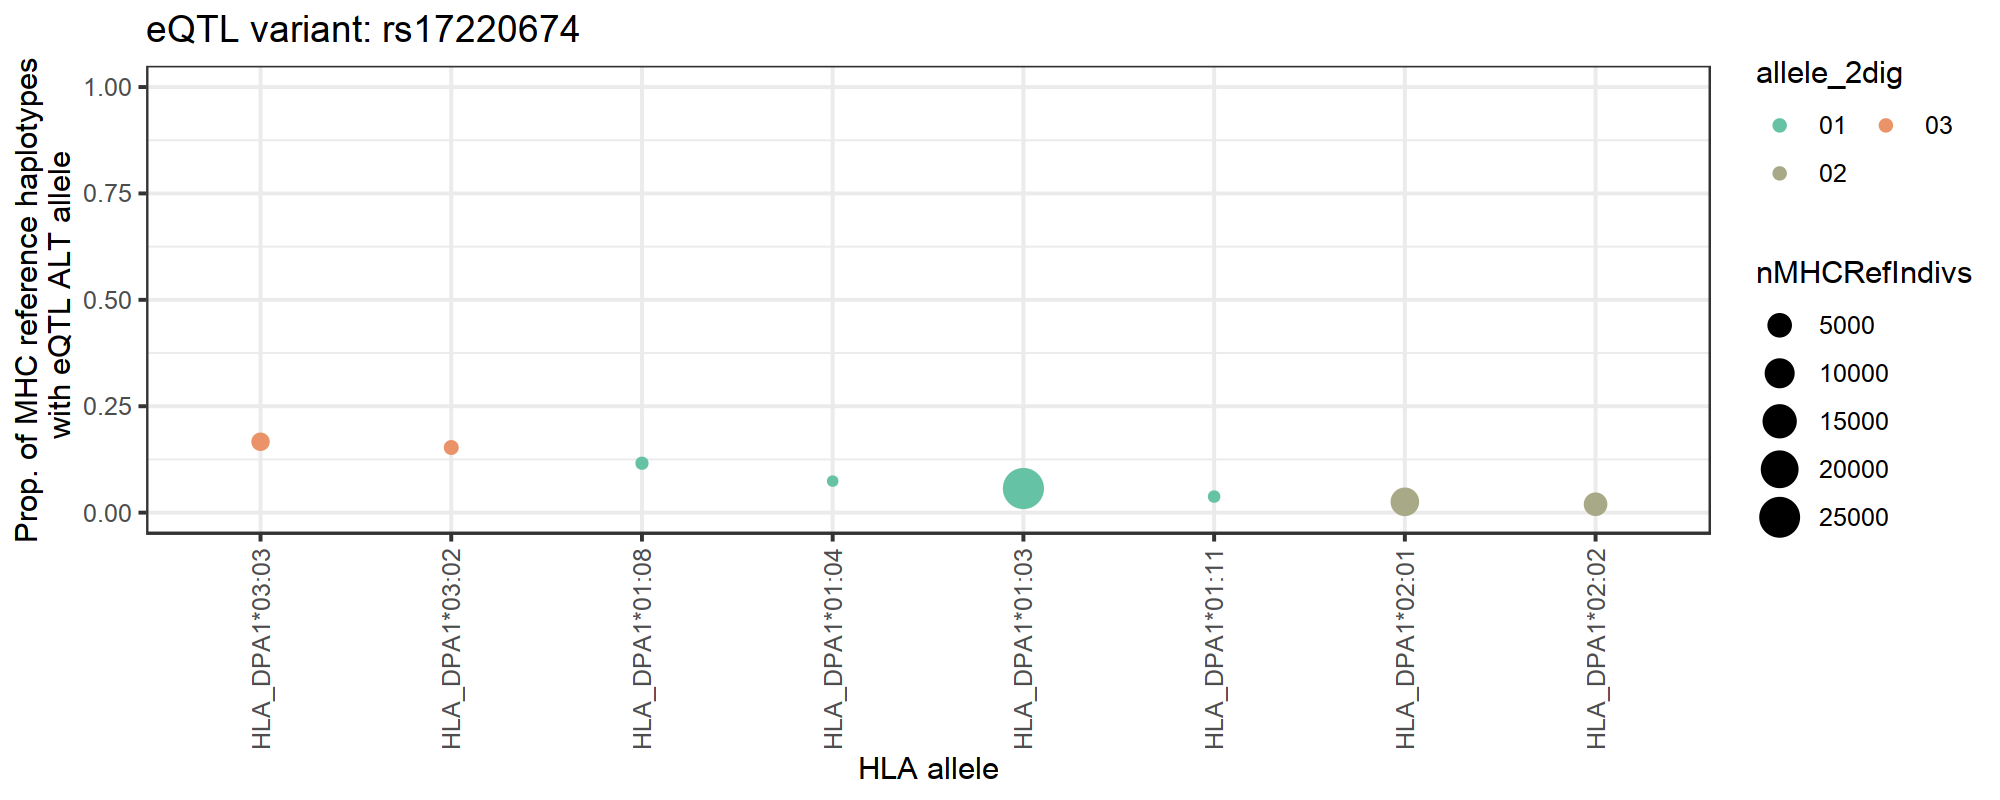

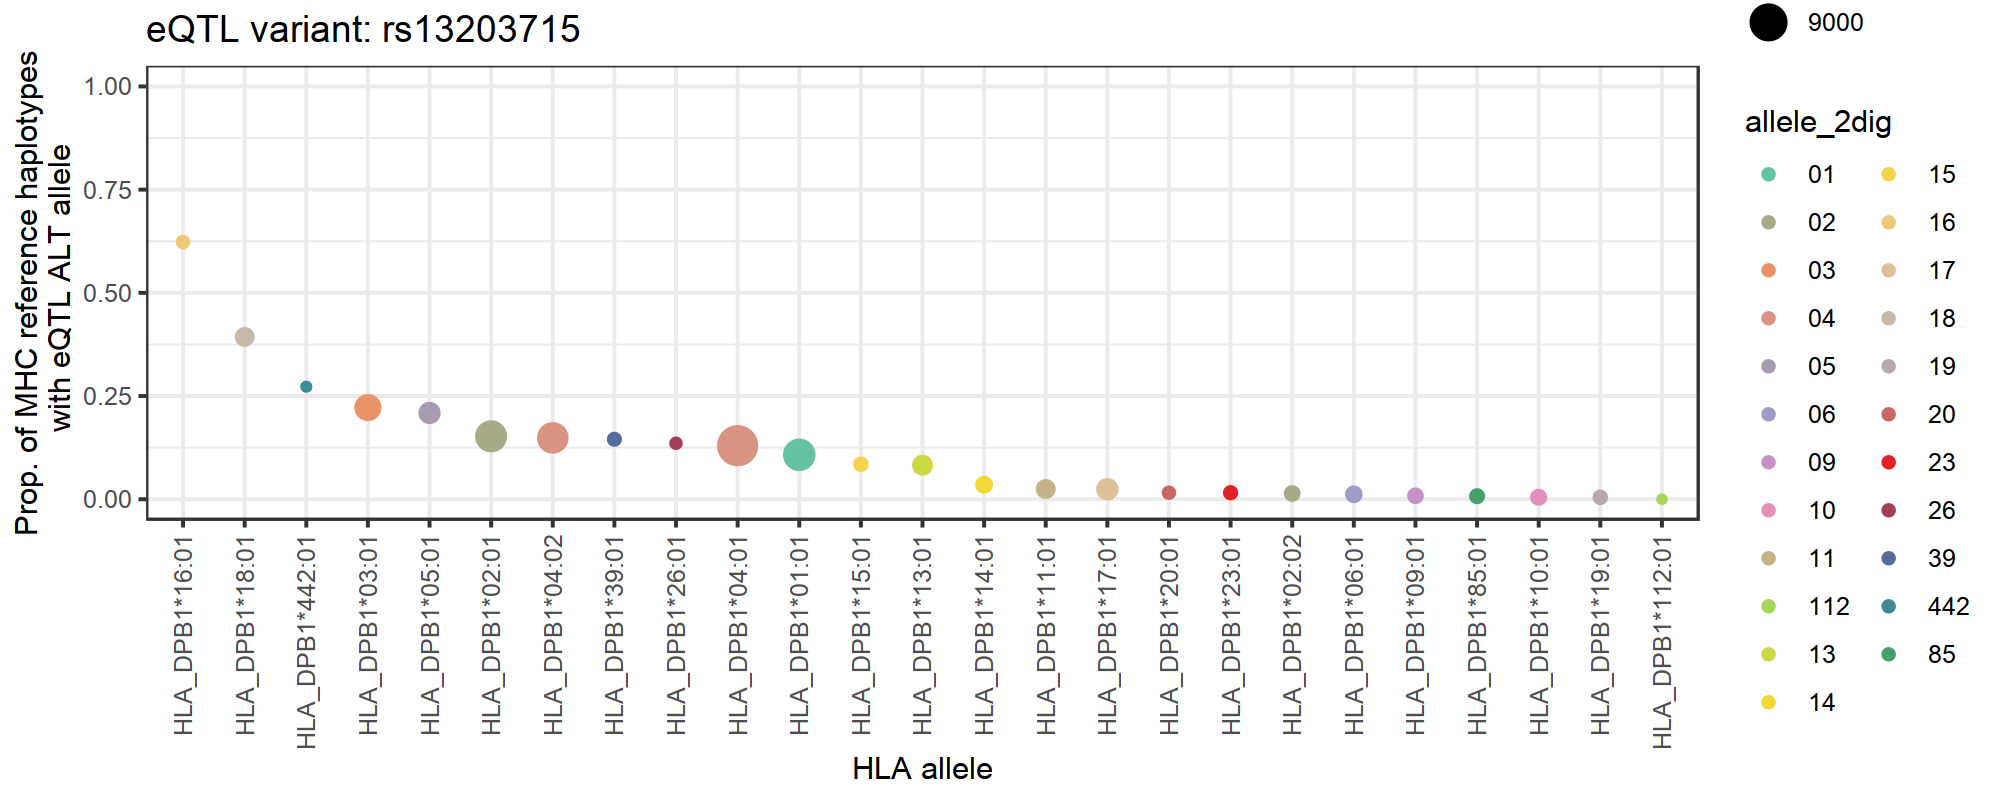

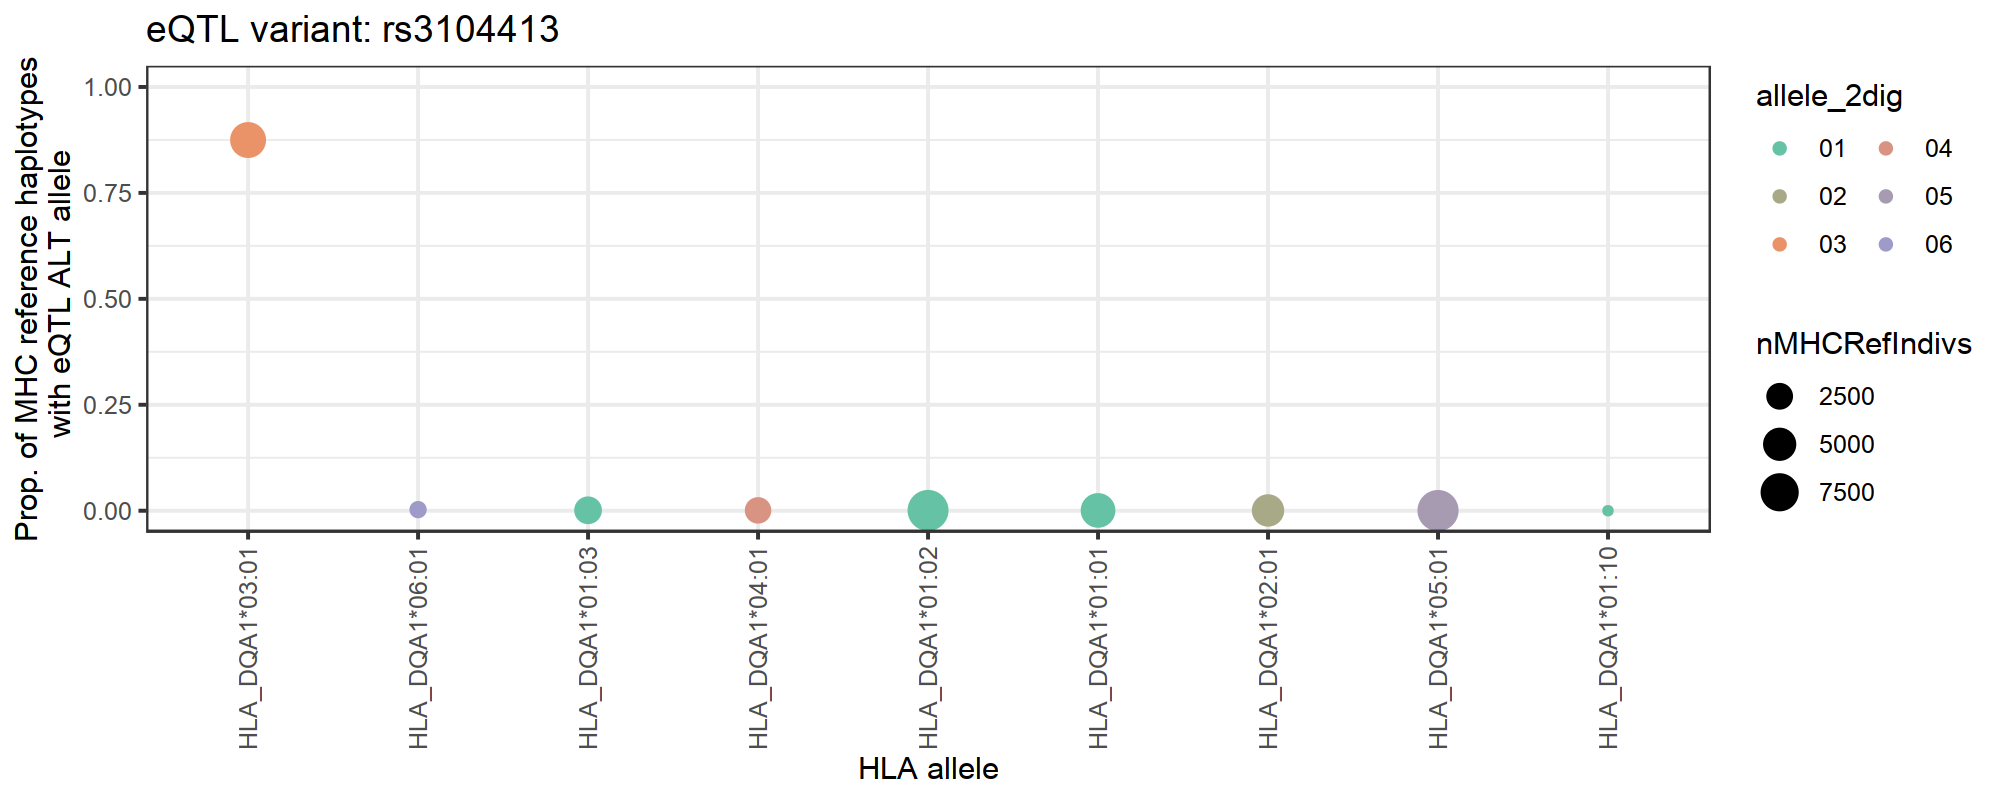

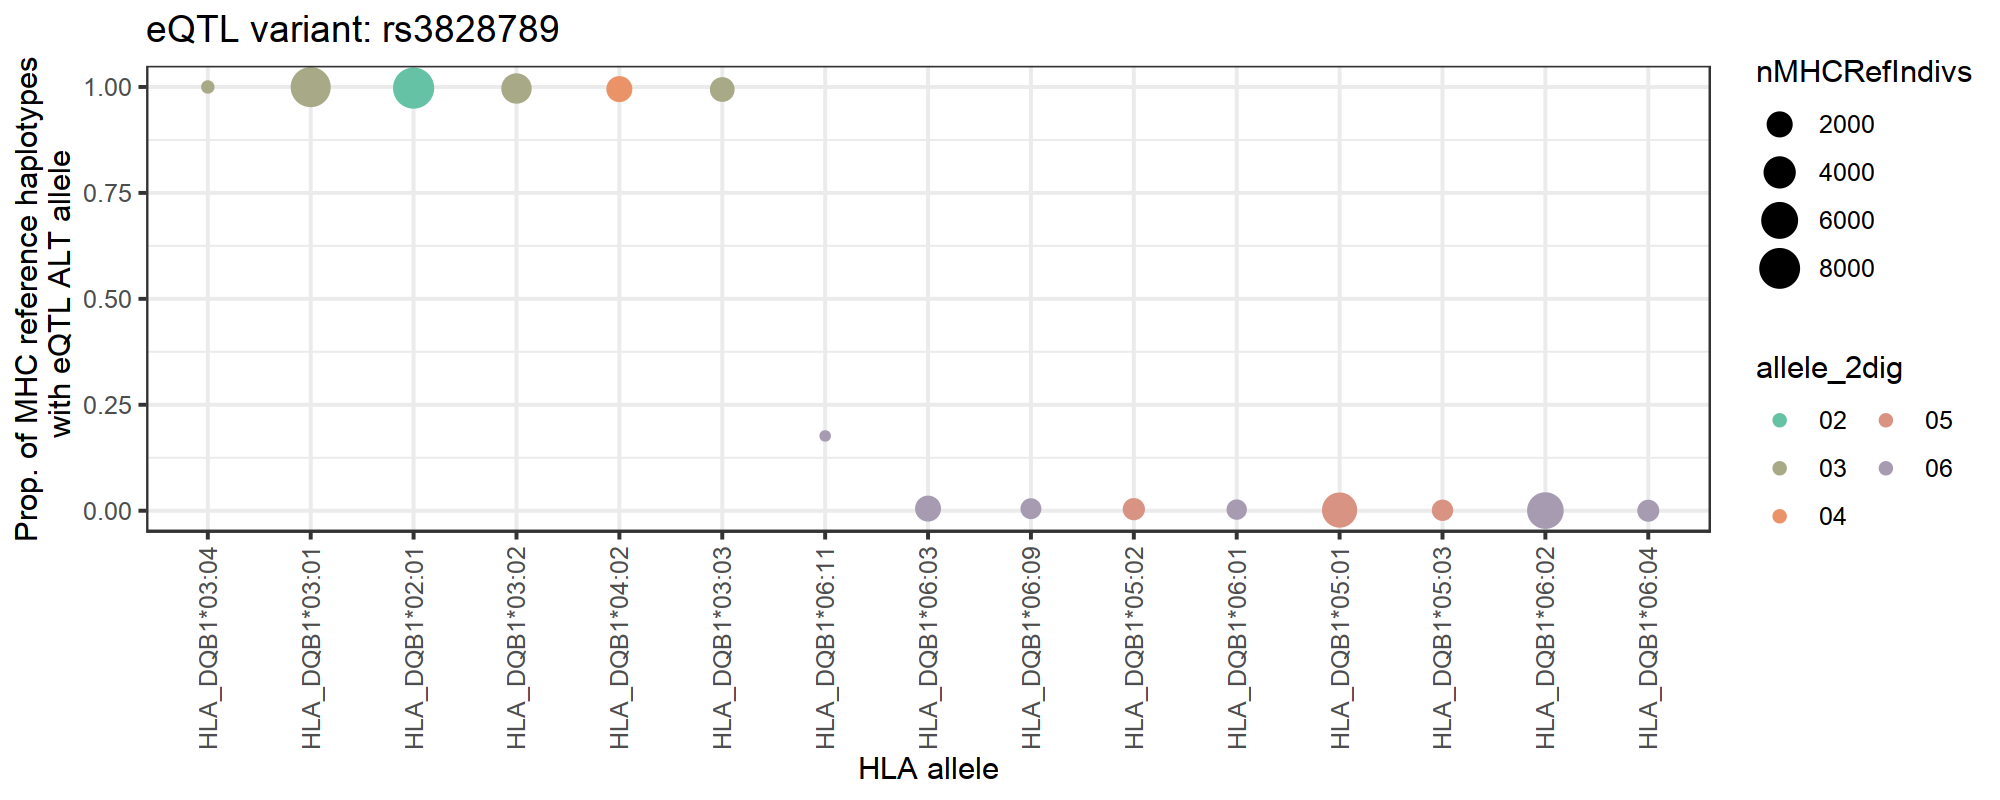

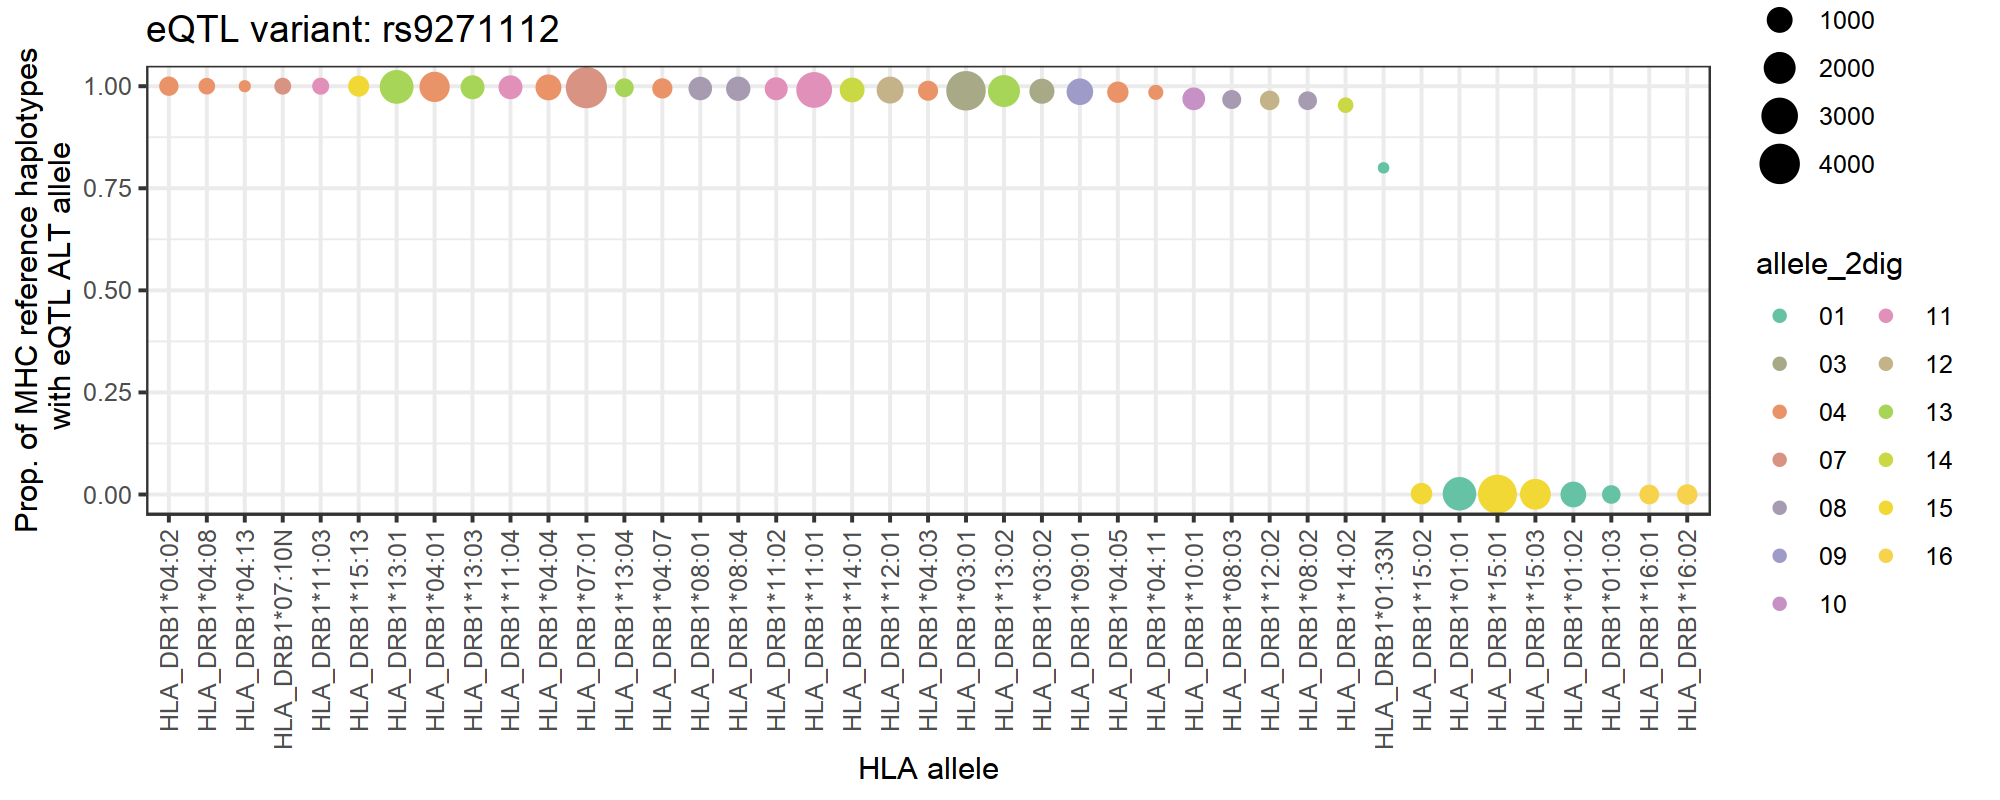

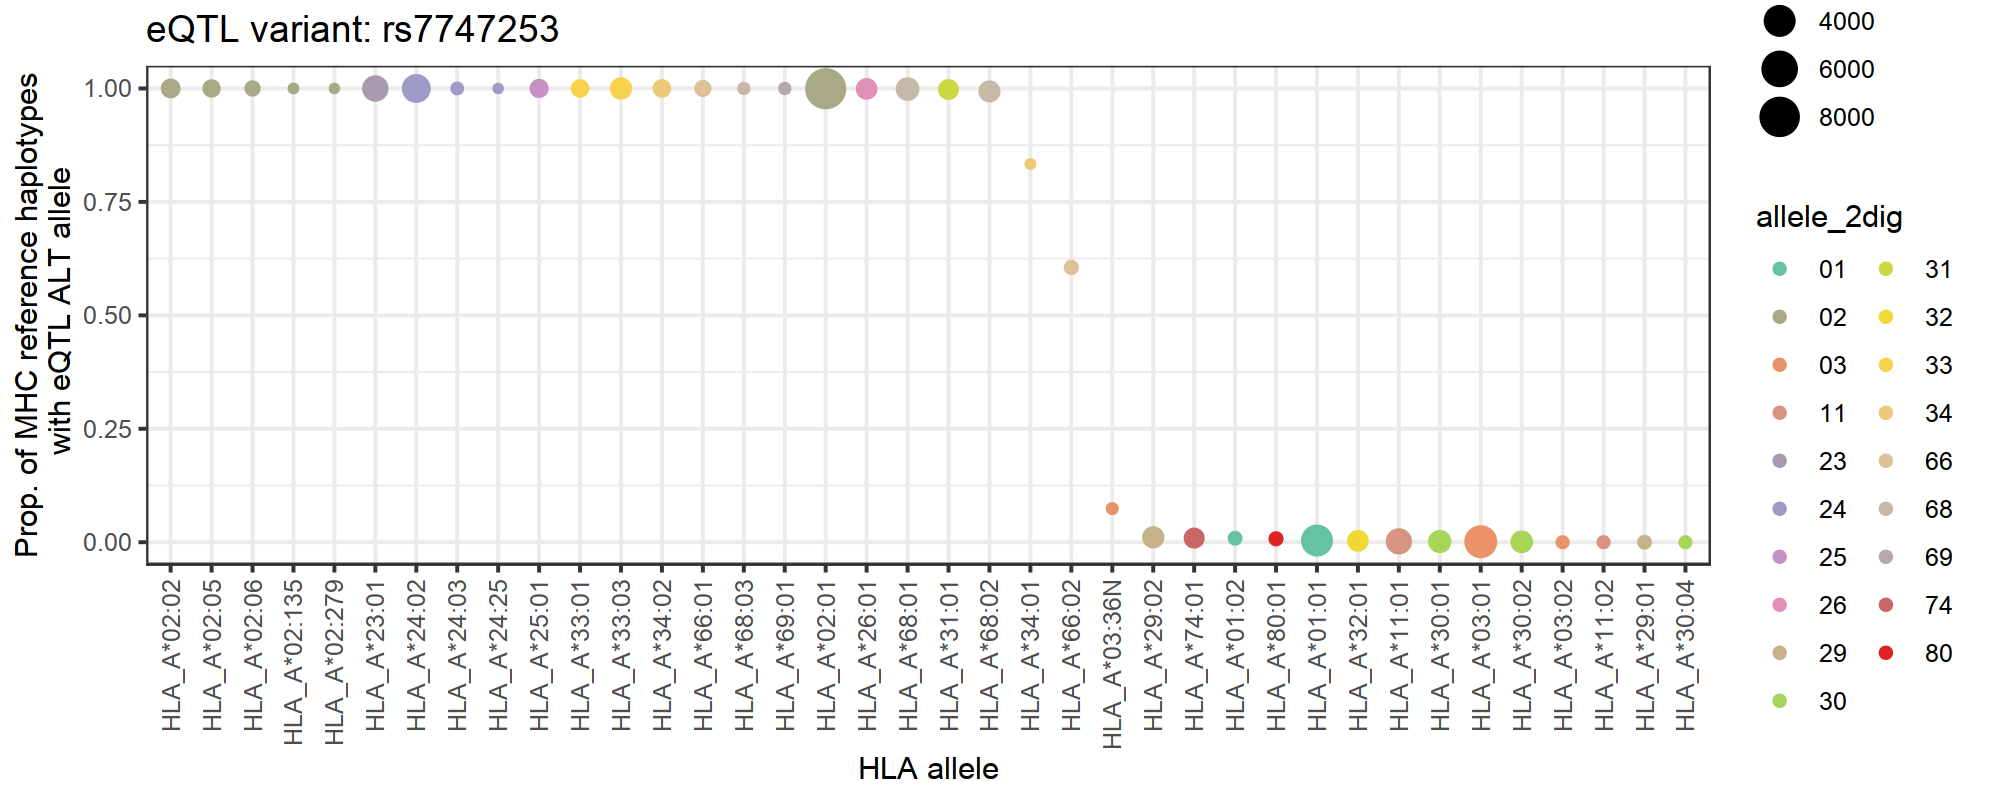

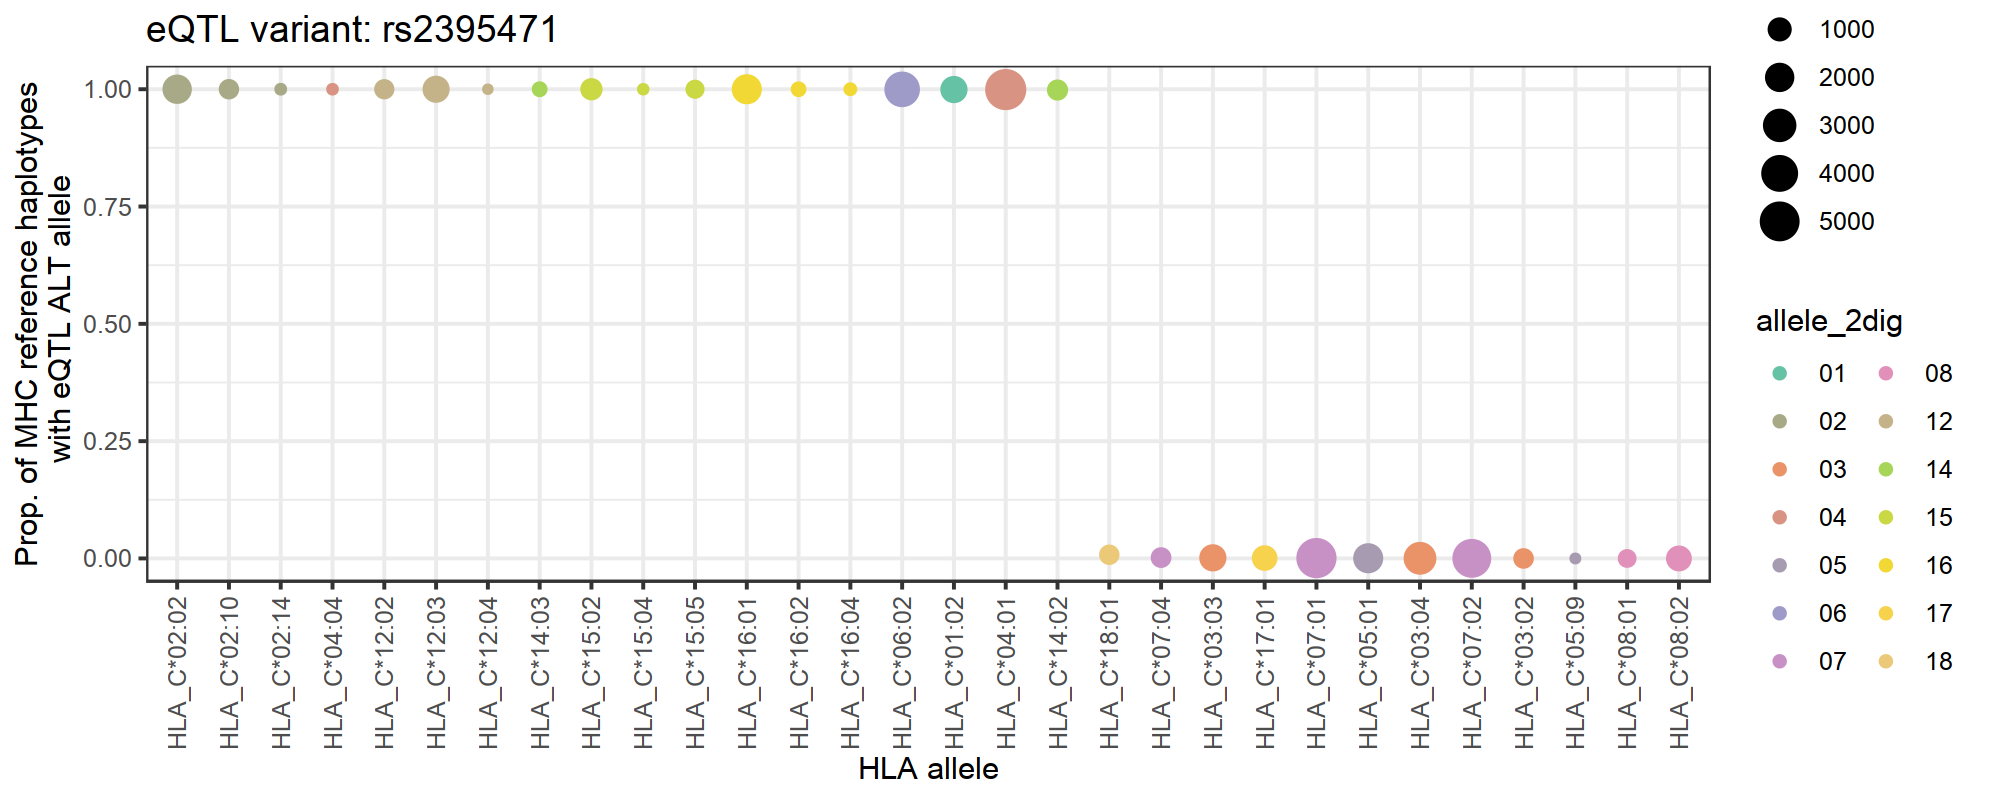

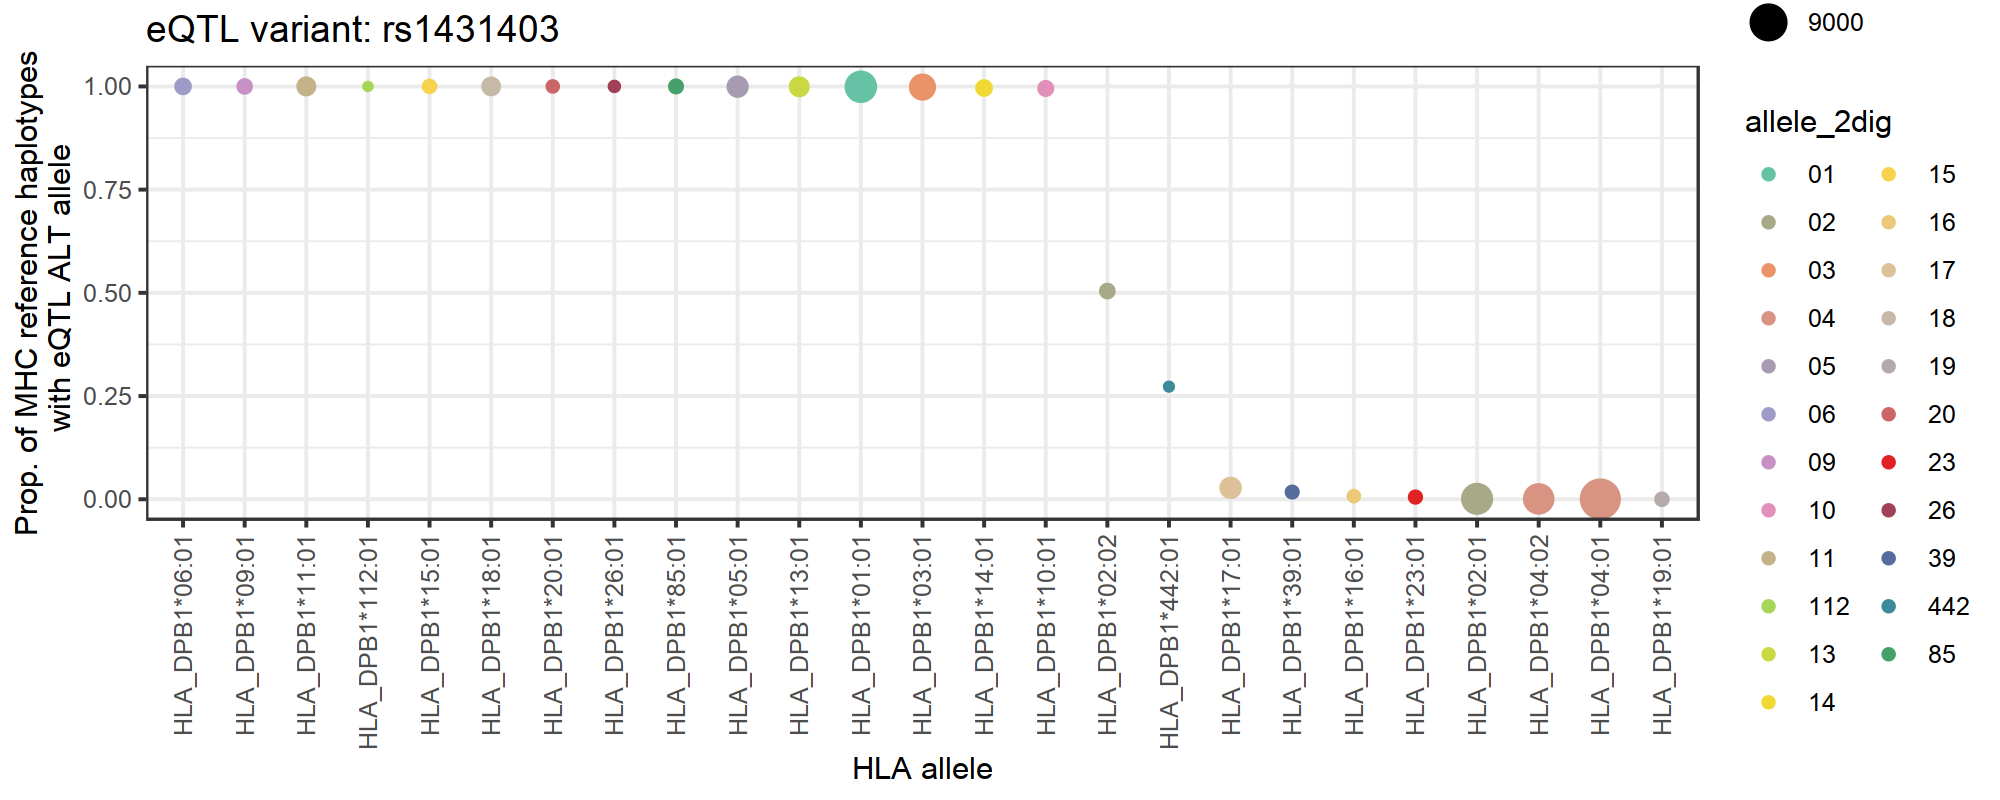

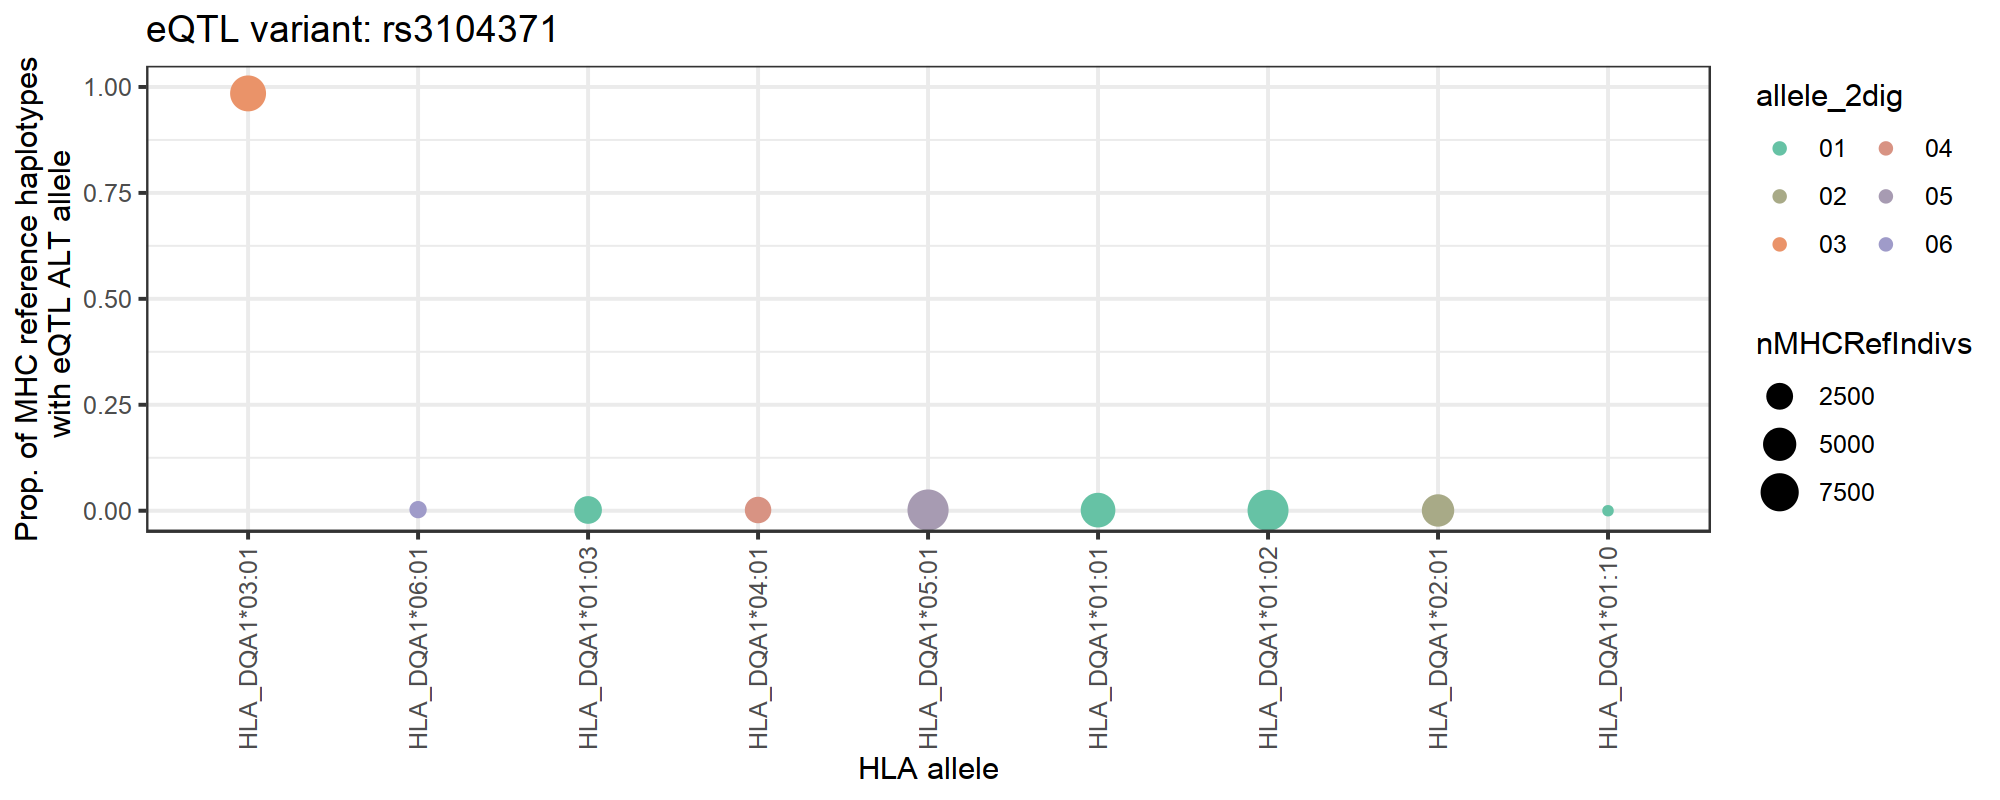

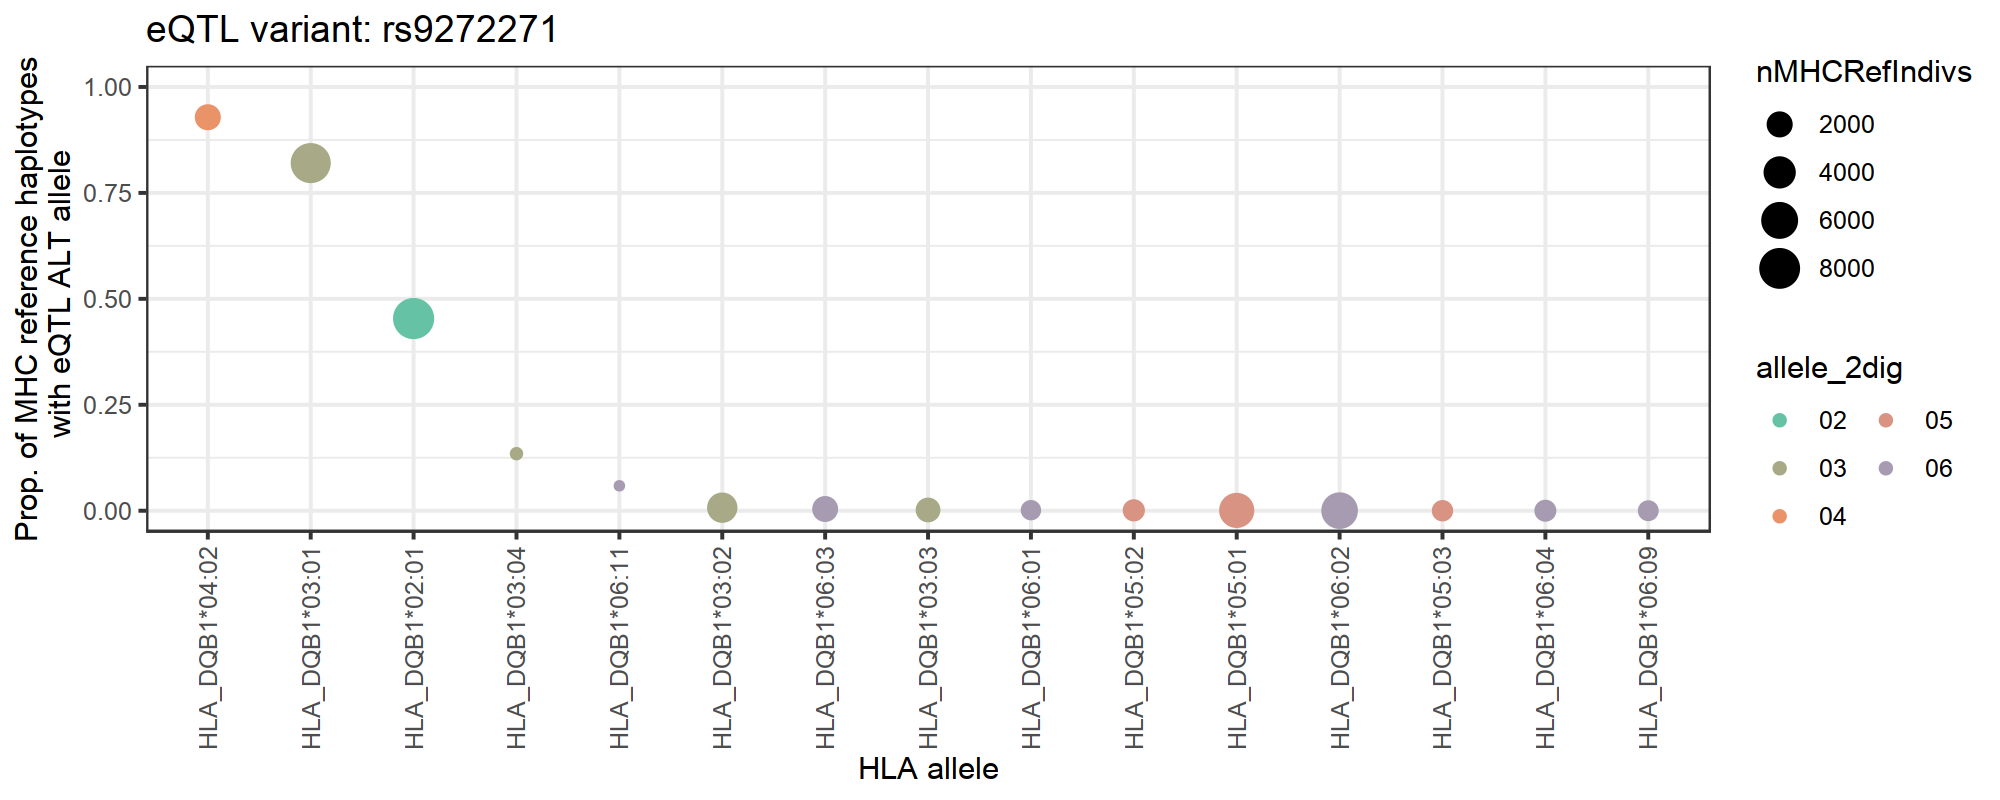

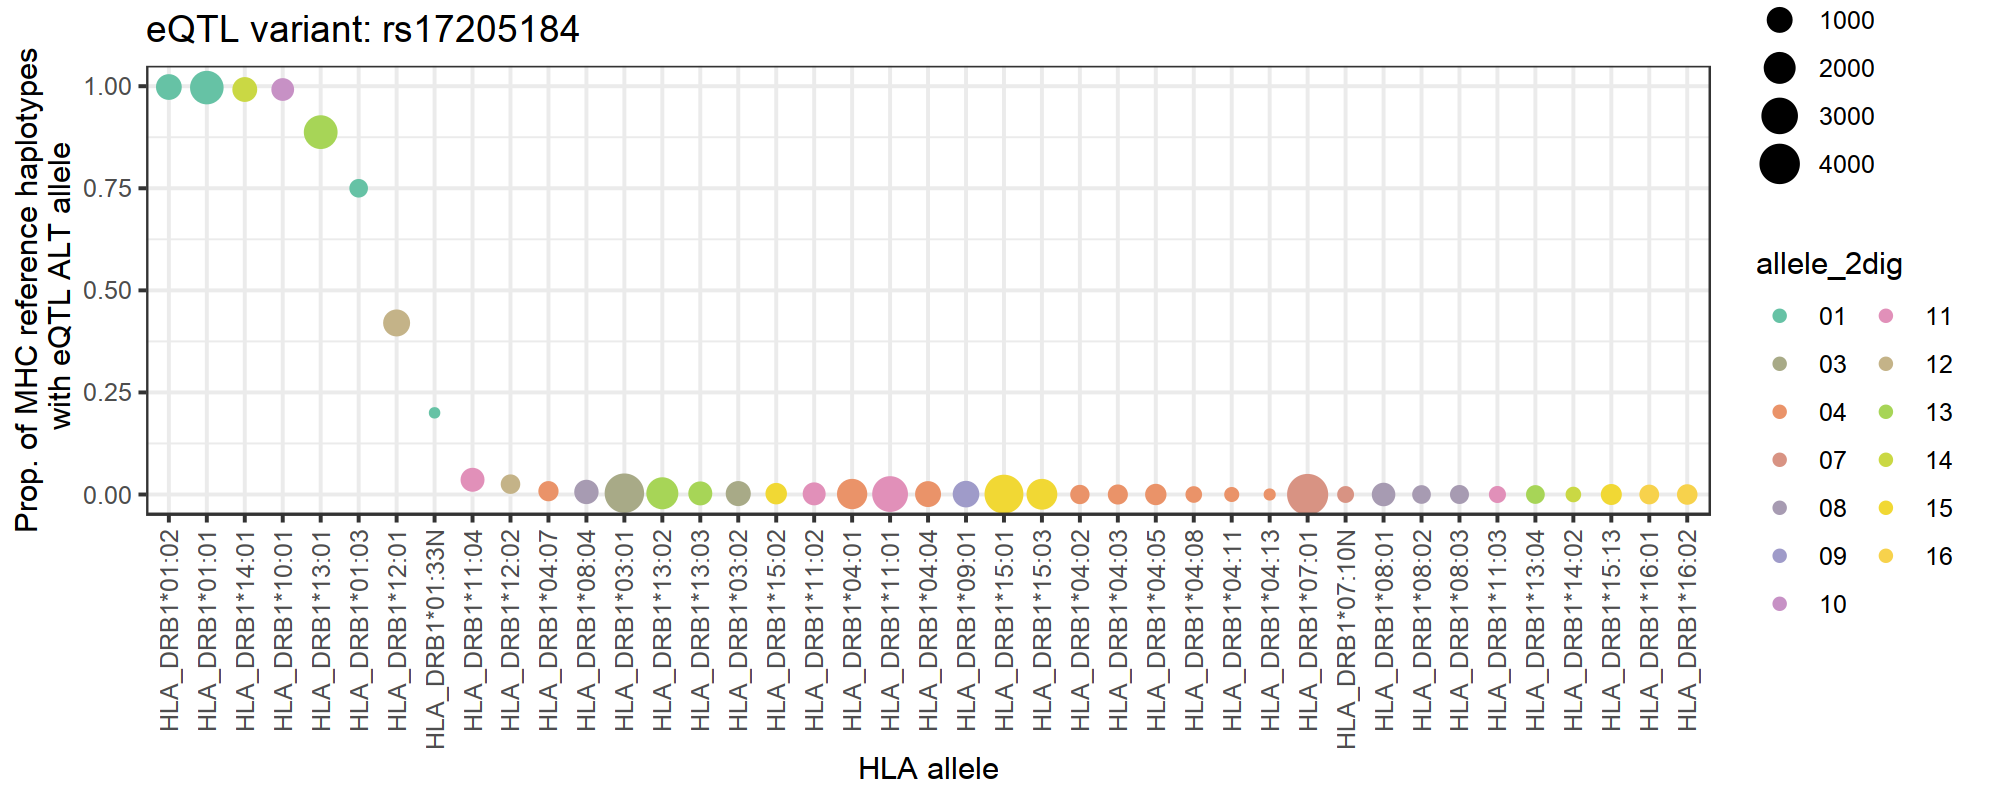

In [16]:
fig.size(4, 10)
res_all = NULL
for (l in 1:nrow(leads)) {
    v = leads[l, 'variant']
    if (v %in% colnames(variant_occs)) {
        gene = leads[l, 'gene']
        HLA_alleles_study_gene = HLA_alleles_study %>% filter(Gene == str_replace(gene, '-', '_'))
        hla_occs = readRDS(paste0('7_HLA_occurrences/', gene, '_occurrences.rds'))
        # Restrict to HLA alleles found in our cohorts
        hla_occs = hla_occs[, unique(HLA_alleles_study_gene$Allele)]
        cooccurrent_plot_res = make_cooccurrence_plot(v, str_replace(gene, 'HLA-', ''))
        cooccurrent_plot_res[['result']]$variant_REF = leads[l, 'REF']
        cooccurrent_plot_res[['result']]$variant_ALT = leads[l, 'ALT']
        res_all = rbind(res_all, cooccurrent_plot_res[['result']])
        print(cooccurrent_plot_res[['p']])
    }
}

## Write supp table

In [17]:
dim(res_all)
res_all$gene = paste0('HLA-', res_all$gene)

[1] 460  10

In [18]:
res_all$allele_2dig = NULL
colnames(res_all) = c('variant', 'gene', 'HLA_allele', 'nHaplos_wALT', 'nHaplos_wREF', 
                      'nHaplos_withAllele', 'perc_ALT', 'variant_REF', 'variant_ALT')
res_all = res_all[ , c('variant', 'variant_REF','variant_ALT', 'gene', 
                      'HLA_allele', 'nHaplos_wREF', 'nHaplos_wALT', 
                      'nHaplos_withAllele', 'perc_ALT')]
res_all$perc_ALT = round(res_all$perc_ALT, 3)
head(res_all)

,variant,variant_REF,variant_ALT,gene,HLA_allele,nHaplos_wREF,nHaplos_wALT,nHaplos_withAllele,perc_ALT
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<dbl>
1,rs417162,C,T,HLA-A,HLA_A*69:01,0,36,36,1
2,rs417162,C,T,HLA-A,HLA_A*68:01,0,1446,1446,1
3,rs417162,C,T,HLA-A,HLA_A*25:01,0,566,566,1
4,rs417162,C,T,HLA-A,HLA_A*26:01,0,1008,1008,1
5,rs417162,C,T,HLA-A,HLA_A*02:06,0,230,230,1
6,rs417162,C,T,HLA-A,HLA_A*02:05,0,459,459,1


In [19]:
write.csv(res_all, '../SuppTables/Table_variants_grouping_HLA_alleles.csv', quote = F, row.names = F)

# Plot HLA expression per 2-field allele

In [1]:
suppressPackageStartupMessages({
    library(tidyr)
    library(dplyr)
    library(plyr)
    library(Matrix)
    library(Matrix.utils)
    library(singlecellmethods)
    library(irlba)
    library(symphony)
    library(ggplot2)
    library(patchwork)
    library(stringr)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}

In [2]:
plotAlleles = function(reference, alleles, gene, celltype) {
    alleles = alleles %>% filter(Gene == paste0('HLA_', gene))
    reference$meta_data$GENE = reference$exp_norm_HLA[paste0('HLA-', gene), ]
    exp_by_donor = reference$meta_data %>% dplyr::group_by(dataset, Sample) %>% dplyr::summarise(mean_exp = mean(GENE))
    df = merge(alleles, exp_by_donor, by = 'Sample') %>%
         arrange(dosage)
    p = ggplot(df) +
        geom_jitter(aes(x = reorder(Allele, mean_exp), y = mean_exp, col = dosage), size = 1.5, shape = 1, width = 0.2, stroke = 0.6) +
        stat_summary(aes(x = reorder(Allele, mean_exp), y = mean_exp), fun = "mean", geom = "point", col = 'black', shape = 18, size = 2) + 
        theme_classic() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
        theme(axis.title.x = element_blank()) +
        scale_color_gradient(low = "yellow", high = "red", na.value = NA) +
        ylab(paste0('HLA-', gene, ' mean log(CP10k+1)\nexpression across cells')) + ggtitle(paste0('HLA-', gene))
        #ggtitle(paste0('HLA-', gene, ' | OneK1K | ', celltype))
    
    return(p)
}

## Psoriasis HLA*C06

In [3]:
psorHLAC = c('HLA_C_06.02', 'HLA_C_12.03')

In [6]:
data = read.csv('./4_multidataset_eQTLs/Myeloid_all_variants.csv')
data %>% filter(startsWith(variant, 'HLA')) %>% arrange(p.val) %>% 
        filter(variant %in% psorHLAC, gene == 'HLA-C') %>% head()

,X,variant,cell_type,gene,beta,stderr,t.val,p.val,CHROM,POS,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,29965,HLA_C_06.02,Myeloid,HLA-C,0.967,0.052,18.749,1.267e-67,chr6,31268773,A,T,0.97,IMP,0.08,0.05,0.08,0.09,31236550
2,29973,HLA_C_12.03,Myeloid,HLA-C,0.499,0.088,5.652,2.060e-08,chr6,31268789,A,T,0.94,IMP,0.07,0.05,0.02,0.03,31236566


In [7]:
data = read.csv('./4_multidataset_eQTLs/B_plasma_all_variants.csv')
data %>% filter(startsWith(variant, 'HLA')) %>% arrange(p.val) %>% 
        filter(variant %in% psorHLAC, gene == 'HLA-C') %>% head()

,X,variant,cell_type,gene,beta,stderr,t.val,p.val,CHROM,POS,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,29965,HLA_C_06.02,B,HLA-C,0.748,0.054,13.778,7.317e-40,chr6,31268773,A,T,0.97,IMP,0.08,0.05,0.08,0.09,31236550
2,29973,HLA_C_12.03,B,HLA-C,0.526,0.089,5.891,5.151e-09,chr6,31268789,A,T,0.94,IMP,0.07,0.05,0.02,0.03,31236566


In [8]:
data = read.csv('./4_multidataset_eQTLs/T_all_variants.csv')
data %>% filter(startsWith(variant, 'HLA')) %>% arrange(p.val) %>%
    filter(variant %in% psorHLAC, gene == 'HLA-C') %>% head()

,X,variant,cell_type,gene,beta,stderr,t.val,p.val,CHROM,POS,REF,ALT,DR2,Imputed,AMP2RA_MAF,Smillie_MAF,Randolph_MAF,OneK1K_MAF,hg19_POS
,<int>,<chr>,<lgl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,29965,HLA_C_06.02,TRUE,HLA-C,0.711,0.039,18.035,1.123e-63,chr6,31268773,A,T,0.97,IMP,0.08,0.05,0.08,0.09,31236550
2,29973,HLA_C_12.03,TRUE,HLA-C,0.564,0.067,8.367,1.838e-16,chr6,31268789,A,T,0.94,IMP,0.07,0.05,0.02,0.03,31236566


## B cells / HLA-C: Plot expression per allele in OneK1K

In [23]:
alleles = read.csv('../data/hla_alleles/HLA_alleles_table_OneK1K.csv')
reference = readRDS('../symphony/AllCohorts_B_plasma_sample0.5batch0.5dataset0.5_reference.rds')

In [24]:
gene = 'C'
allelesC = alleles %>% filter(Gene == paste0('HLA_', 'C'))
reference$meta_data$GENE = reference$exp_norm_HLA[paste0('HLA-', gene), ]
exp_by_donor = reference$meta_data %>% dplyr::group_by(dataset, Sample) %>% dplyr::summarise(mean_exp = mean(GENE))
df = merge(allelesC, exp_by_donor, by = 'Sample') %>%
         arrange(dosage)
head(df)

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.


,Sample,X,Geno_ID,Allele,Gene,GT,dosage,dataset,mean_exp
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,212_213,11198,212_213,HLA_C*05:01,HLA_C,0|1,0.51,OneK1K,2.017196
2,368_369,4754,368_369,HLA_C*03:04,HLA_C,0|1,0.56,OneK1K,2.468559
3,239_240,11227,239_240,HLA_C*05:01,HLA_C,1|0,0.59,OneK1K,2.070890
4,390_391,4913,390_391,HLA_C*05:01,HLA_C,0|1,0.76,OneK1K,2.105848
5,98_98,5584,98_98,HLA_C*14:02,HLA_C,1|0,0.79,OneK1K,1.614741
6,189_190,10503,189_190,HLA_C*07:02,HLA_C,1|0,0.80,OneK1K,2.179111


In [25]:
# Filter to alleles that have > 2 individuals
allele_keep = (df %>% group_by(Allele) %>% dplyr::summarise(n = n()) %>% filter(n > 0))$Allele
df = df %>% filter(Allele %in% allele_keep)

png 
  2

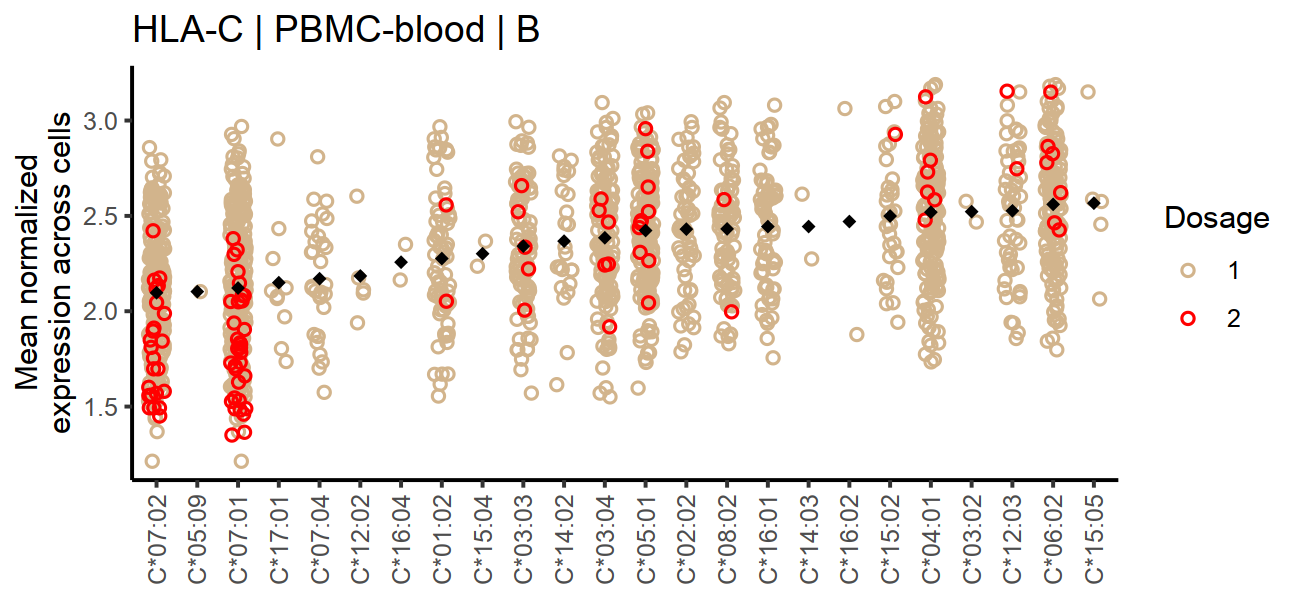

In [27]:
fig.size(3, 6.5)
pdf('../SuppFigs/HLA-C_Alleles_B_plasma_OneK1K.pdf', width = 6.5, height = 3)
p = ggplot(df) +
        geom_jitter(aes(x = reorder(str_replace(Allele, 'HLA_', ''), mean_exp), y = mean_exp, 
                        col = as.factor(round(dosage))), size = 1.5, shape = 1, width = 0.2, stroke = 0.6) +
        stat_summary(aes(x = reorder(str_replace(Allele, 'HLA_', ''), mean_exp), y = mean_exp), fun = "mean", geom = "point", col = 'black', shape = 18, size = 2) + 
        theme_classic() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
        theme(axis.title.x = element_blank()) +
        ylab(paste0('Mean normalized\nexpression across cells')) + 
        ggtitle(paste0('HLA-', gene, ' | PBMC-blood | B')) + labs(col = 'Dosage') + scale_color_manual(values = c('tan', 'red'))
print(p)
dev.off()
p

## Myeloid / HLA-B: Plot expression per allele in OneK1K

In [28]:
reference = readRDS('../symphony/AllCohorts_Myeloid_sample0.5batch0.5dataset0.5_reference.rds')

In [30]:
gene = 'B'
allelesB = alleles %>% filter(Gene == paste0('HLA_', 'B'))
reference$meta_data$GENE = reference$exp_norm_HLA[paste0('HLA-', gene), ]
exp_by_donor = reference$meta_data %>% dplyr::group_by(dataset, Sample) %>% dplyr::summarise(mean_exp = mean(GENE))
df = merge(allelesB, exp_by_donor, by = 'Sample') %>%
         arrange(dosage)
head(df)

`summarise()` has grouped output by 'dataset'. You can override using the `.groups` argument.


,Sample,X,Geno_ID,Allele,Gene,GT,dosage,dataset,mean_exp
,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,939_940,12041,939_940,HLA_B*15:01,HLA_B,1|0,0.50,OneK1K,2.830171
2,595_596,8081,595_596,HLA_B*15:01,HLA_B,1|0,0.51,OneK1K,2.580434
3,15_15,11554,15_15,HLA_B*07:04,HLA_B,0|1,0.52,OneK1K,2.966213
4,471_472,6718,471_472,HLA_B*18:01,HLA_B,0|1,0.52,OneK1K,2.835608
5,845_846,450,845_846,HLA_B*27:05,HLA_B,1|0,0.52,OneK1K,3.184047
6,10_10,11097,10_10,HLA_B*18:01,HLA_B,0|1,0.53,OneK1K,3.002815


In [31]:
# Filter to alleles that have > 2 individuals
allele_keep = (df %>% group_by(Allele) %>% dplyr::summarise(n = n()) %>% filter(n > 0))$Allele
df = df %>% filter(Allele %in% allele_keep)

png 
  2

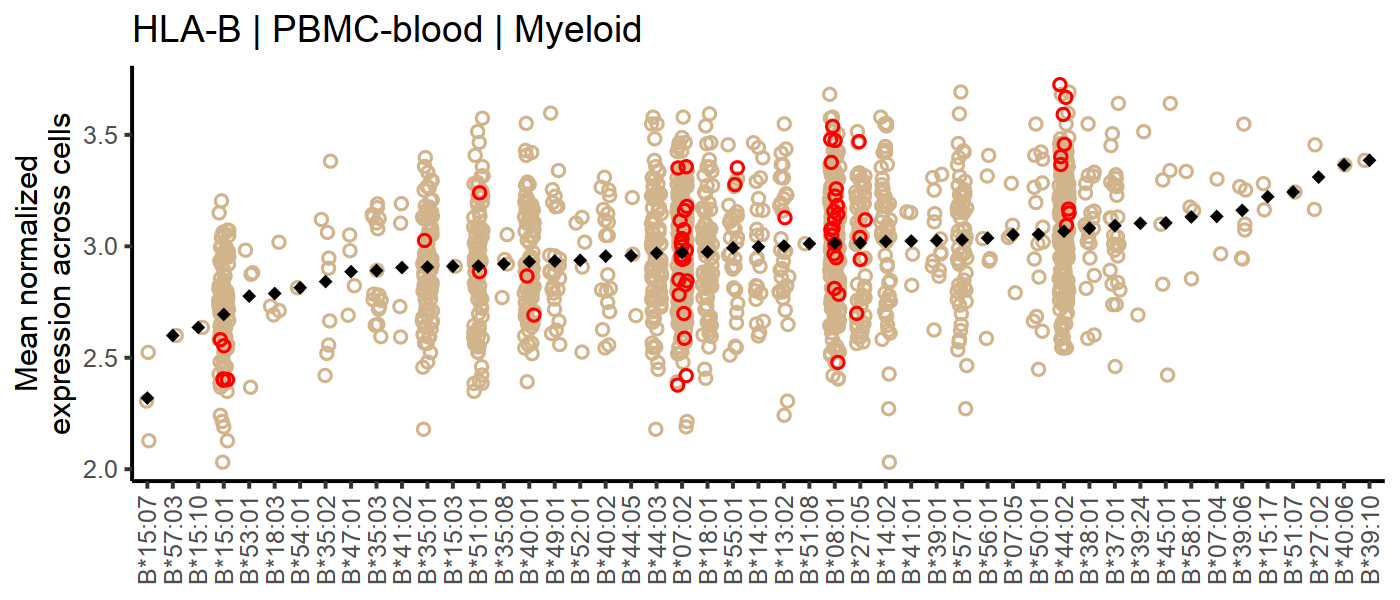

In [32]:
fig.size(3, 7)
pdf('../SuppFigs/HLA-B_Alleles_Myeloid_OneK1K.pdf', width = 7, height = 3)
p = ggplot(df) +
        geom_jitter(aes(x = reorder(str_replace(Allele, 'HLA_', ''), mean_exp), y = mean_exp, 
                        col = as.factor(round(dosage+0.01))), size = 1.5, shape = 1, width = 0.2, stroke = 0.6) +
        stat_summary(aes(x = reorder(str_replace(Allele, 'HLA_', ''), mean_exp), 
                         y = mean_exp), fun = "mean", geom = "point", col = 'black', shape = 18, size = 2) + 
        theme_classic() + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
        theme(axis.title.x = element_blank()) +
        ylab(paste0('Mean normalized\nexpression across cells')) + 
        ggtitle(paste0('HLA-', gene, ' | PBMC-blood | Myeloid')) + labs(col = 'Dosage') + 
        scale_color_manual(values = c('tan', 'red')) + theme(legend.position = 'none')
print(p)
dev.off()
p

# All done!

In [20]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux Server release 6.5 (Santiago)

Matrix products: default
BLAS/LAPACK: /PHShome/jbk37/anaconda3/envs/hla_new/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] RColorBrewer_1.1-3 data.table_1.14.8  forcats_0.5.1      stringr_1.4.0     
 [5] dplyr_1.0.8        purrr_0.3.4        readr_2.1.2        tidyr_1.2.0       
 [9] tibble_3.1.6       ggplot2_3.3.5      tidyverse_1.3.1    vcfR_1.12.0       

loaded via a namespace